# Load the main libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from catboost import CatBoostClassifier
from sklearn.feature_selection import SelectKBest

# Load Dataset

In [2]:
#import the data
train_url = '/kaggle/input/playground-series-s3e7/train.csv'
test_url = '/kaggle/input/playground-series-s3e7/test.csv'
original_url = '/kaggle/input/reservation-cancellation-prediction/train__dataset.csv'

df_train = pd.read_csv(train_url)
df_train.drop("id",axis=1,inplace=True)

df_test= pd.read_csv(test_url,index_col='id')

df_original = pd.read_csv(original_url)



#showing the first 5 rows of data
df_train.head(10)

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0             2               0                     0                  2   
1             2               0                     1                  2   
2             2               0                     0                  1   
3             1               0                     0                  2   
4             2               0                     1                  0   
5             0               2                     2                  5   
6             2               0                     0                  1   
7             2               0                     0                  2   
8             2               0                     2                  3   
9             3               0                     0                  3   

   type_of_meal_plan  required_car_parking_space  room_type_reserved  \
0                  1                           0                   0   
1                  0                           0                   0   
2                  0                           0                   0   
3                  1                           0                   0   
4                  0                           0                   0   
5                  0                           0                   2   
6                  2                           0                   0   
7                  2                           0                   0   
8                  0                           0                   0   
9                  0                           0                   0   

   lead_time  arrival_year  arrival_month  arrival_date  market_segment_type  \
0          9          2018              1            14                    1   
1        117          2018              7            29                    0   
2        315          2018             12             2                    0   
3         32          2018             12             1                    1   
4        258          2018             10            16                    0   
5        215          2018             10             6                    1   
6        320          2018              8            18                    0   
7        265          2018              6            24                    0   
8        189          2018             10             8                    0   
9        137          2018             12            22                    1   

   repeated_guest  no_of_previous_cancellations  \
0               1                            11   
1               0                             0   
2               0                             0   
3               0                             0   
4               0                             0   
5               0                             0   
6               0                             0   
7               0                             0   
8               0                             0   
9               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               67.50   
1                                     0               72.25   
2                                     0               52.00   
3                                     0               56.00   
4                                     0              100.00   
5                                     0              212.06   
6                                     0              115.00   
7                                     0               87.00   
8                                     0               72.75   
9                                     0              117.30   

   no_of_special_requests  booking_status  
0                       0               0  
1                       0               0  
2                       0               0  
3                       0               0  
4               

In [3]:
#dropping the duplicated rows in data
sets={'train':df_train,'test':df_test,'original':df_original}

def dropping_duplicates(data):
    data.drop_duplicates(inplace = True)
    
drop_duplcated_list={'train':df_train,'original':df_original}   
for n in drop_duplcated_list:
    print(f"number of duplicated rows in {n} is {sets[n].duplicated().sum()}, they were dropped ")
    dropping_duplicates(sets[n])
    drop_duplcated_list[n].reset_index(drop=True,inplace=True)

number of duplicated rows in train is 0, they were dropped 
number of duplicated rows in original is 4111, they were dropped 


In [4]:
#concatinating the train and original data 
df_train = pd.concat([df_train,df_original],ignore_index=True)

In [5]:
#dropping the duplicated in the concatenated data
print(f"A number of duplicated rows in concatenated train is {df_train.duplicated().sum()}, they were dropped")
dropping_duplicates(df_train)
df_train.reset_index(drop=True,inplace=True)

A number of duplicated rows in concatenated train is 1553, they were dropped


## **Dataset Description** 
<font color='red'>

- **No of adults:** Number of adults

- **No of children:** Number of Children

- **noofweekend_nights:** Number of weekend nights (Saturday or Sunday) the guest - stayed or booked to stay at the hotel

- **noofweek_nights:** Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel

- **typeofmeal_plan:** Type of meal plan booked by the customer
- **requiredcarparking_space:** Does the customer require a car parking space? (0 - No, 1- Yes)
- **roomtypereserved:** Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.

- **lead_time:** Number of days between the date of booking and the arrival date

- **arrival_year:** Year of arrival date

- **arrival_month:** Month of arrival date

- **arrival_date:** Date of the month

- **Market segment type:** Market segment designation.

- **repeated_guest:** Is the customer a repeated guest? (0 - No, 1- Yes)

- **noofprevious_cancellations:** Number of previous bookings that were canceled by the customer prior to the current booking

- **noofpreviousbookingsnot_canceled:** Number of previous bookings not canceled by the customer prior to the current booking

- **avgpriceper_room:** Average price per day of the reservation; prices of the rooms are dynamic. (in euros)

- **noofspecial_requests:** Total number of special requests made by the customer (e.g. high floor, view from the room, etc)

- **_booking_status:** Flag indicating if the booking was canceled or not.
    </font>


In [6]:
#showing some info about the data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54573 entries, 0 to 54572
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          54573 non-null  int64  
 1   no_of_children                        54573 non-null  int64  
 2   no_of_weekend_nights                  54573 non-null  int64  
 3   no_of_week_nights                     54573 non-null  int64  
 4   type_of_meal_plan                     54573 non-null  int64  
 5   required_car_parking_space            54573 non-null  int64  
 6   room_type_reserved                    54573 non-null  int64  
 7   lead_time                             54573 non-null  int64  
 8   arrival_year                          54573 non-null  int64  
 9   arrival_month                         54573 non-null  int64  
 10  arrival_date                          54573 non-null  int64  
 11  market_segment_

In [7]:
#showing some descriptive statics abouth the data 
df_train.describe()

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
count  54573.000000    54573.000000          54573.000000       54573.000000   
mean       1.912631        0.141993              0.882763           2.361094   
std        0.526012        0.455300              0.886632           1.454017   
min        0.000000        0.000000              0.000000           0.000000   
25%        2.000000        0.000000              0.000000           1.000000   
50%        2.000000        0.000000              1.000000           2.000000   
75%        2.000000        0.000000              2.000000           3.000000   
max        4.000000        9.000000              7.000000          17.000000   

       type_of_meal_plan  required_car_parking_space  room_type_reserved  \
count       54573.000000                54573.000000        54573.000000   
mean            0.243948                    0.029648            0.430249   
std             0.573955                    0.169617            0.840717   
min             0.000000                    0.000000            0.000000   
25%             0.000000                    0.000000            0.000000   
50%             0.000000                    0.000000            0.000000   
75%             0.000000                    0.000000            1.000000   
max             3.000000                    1.000000            6.000000   

          lead_time  arrival_year  arrival_month  arrival_date  \
count  54573.000000  54573.000000   54573.000000  54573.000000   
mean      94.360838   2017.854250       7.531911     15.878676   
std       79.931463      0.352858       2.912821      8.884786   
min        0.000000   2017.000000       1.000000      1.000000   
25%       27.000000   2018.000000       5.000000      8.000000   
50%       78.000000   2018.000000       8.000000     16.000000   
75%      144.000000   2018.000000      10.000000     24.000000   
max      443.000000   2018.000000      12.000000     31.000000   

       market_segment_type  repeated_guest  no_of_previous_cancellations  \
count         54573.000000    54573.000000                  54573.000000   
mean              0.783703        0.029997                      0.021861   
std               0.631383        0.170579                      0.351772   
min               0.000000        0.000000                      0.000000   
25%               0.000000        0.000000                      0.000000   
50%               1.000000        0.000000                      0.000000   
75%               1.000000        0.000000                      0.000000   
max               4.000000        1.000000                     13.000000   

       no_of_previous_bookings_not_canceled  avg_price_per_room  \
count                          54573.000000        54573.000000   
mean                               0.184450          104.942294   
std                                1.809858           37.352402   
min                                0.000000            0.000000   
25%                                0.000000           80.100000   
50%                                0.000000           99.880000   
75%                                0.000000          124.800000   
max                               58.000000          540.000000   

       no_of_special_requests  booking_status  
count            54573.000000    54573.000000  
mean                 0.614718        0.365767  
std                  0.789660        0.481649  
min                  0.000000        0.000000  
25%                  0.000000        0.000000  
50%                  0.000000        0.000000  
75%                  1.000000        1.000000  
max                  5.000000        1.000000

In [8]:
df_train.nunique()

no_of_adults                               5
no_of_children                             6
no_of_weekend_nights                       8
no_of_week_nights                         18
type_of_meal_plan                          4
required_car_parking_space                 2
room_type_reserved                         7
lead_time                                341
arrival_year                               2
arrival_month                             12
arrival_date                              31
market_segment_type                        5
repeated_guest                             2
no_of_previous_cancellations              10
no_of_previous_bookings_not_canceled      47
avg_price_per_room                      2834
no_of_special_requests                     6
booking_status                             2
dtype: int64

` All data types are integrs except (avg_price_per_room) column which is float64. Most of the data columns can be treated as categorical (some of them are ordinal) data except (lead_time , avg_price_per_room, no_of_previous_cancellations, no_of_previous_bookings_not_canceled)`

## Data Visualization

In [9]:
#getting the categorical variables
categorical_columns = df_train.columns.drop(['booking_status','avg_price_per_room',
                                            'no_of_previous_bookings_not_canceled',
                                            'no_of_previous_cancellations',
                                            'lead_time',
                                            'arrival_date'])

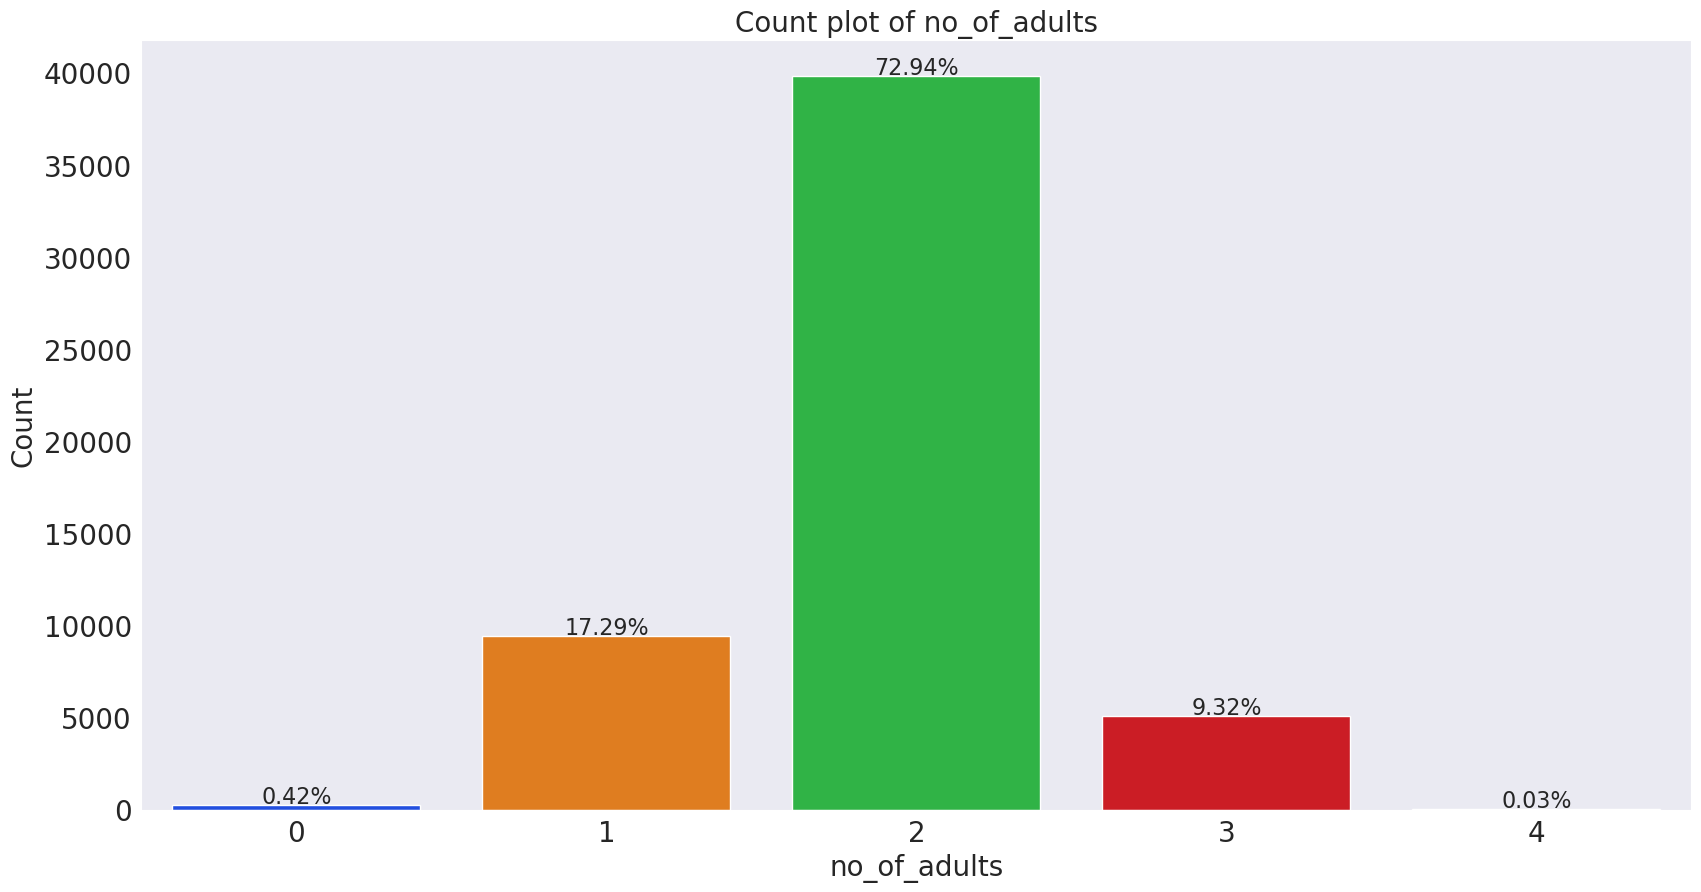

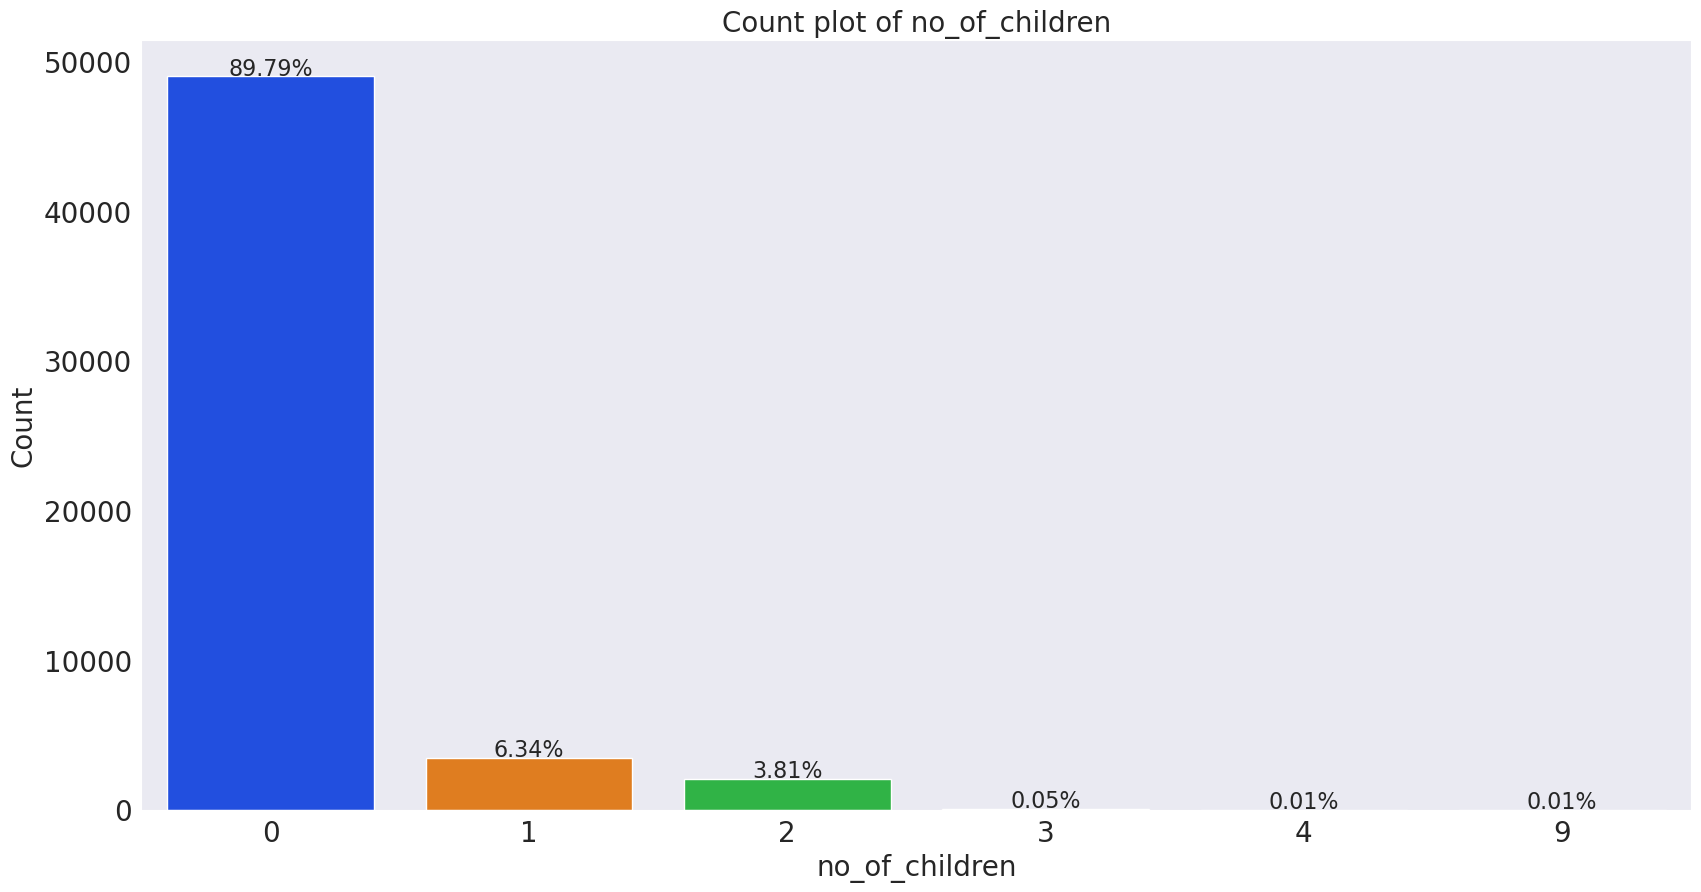

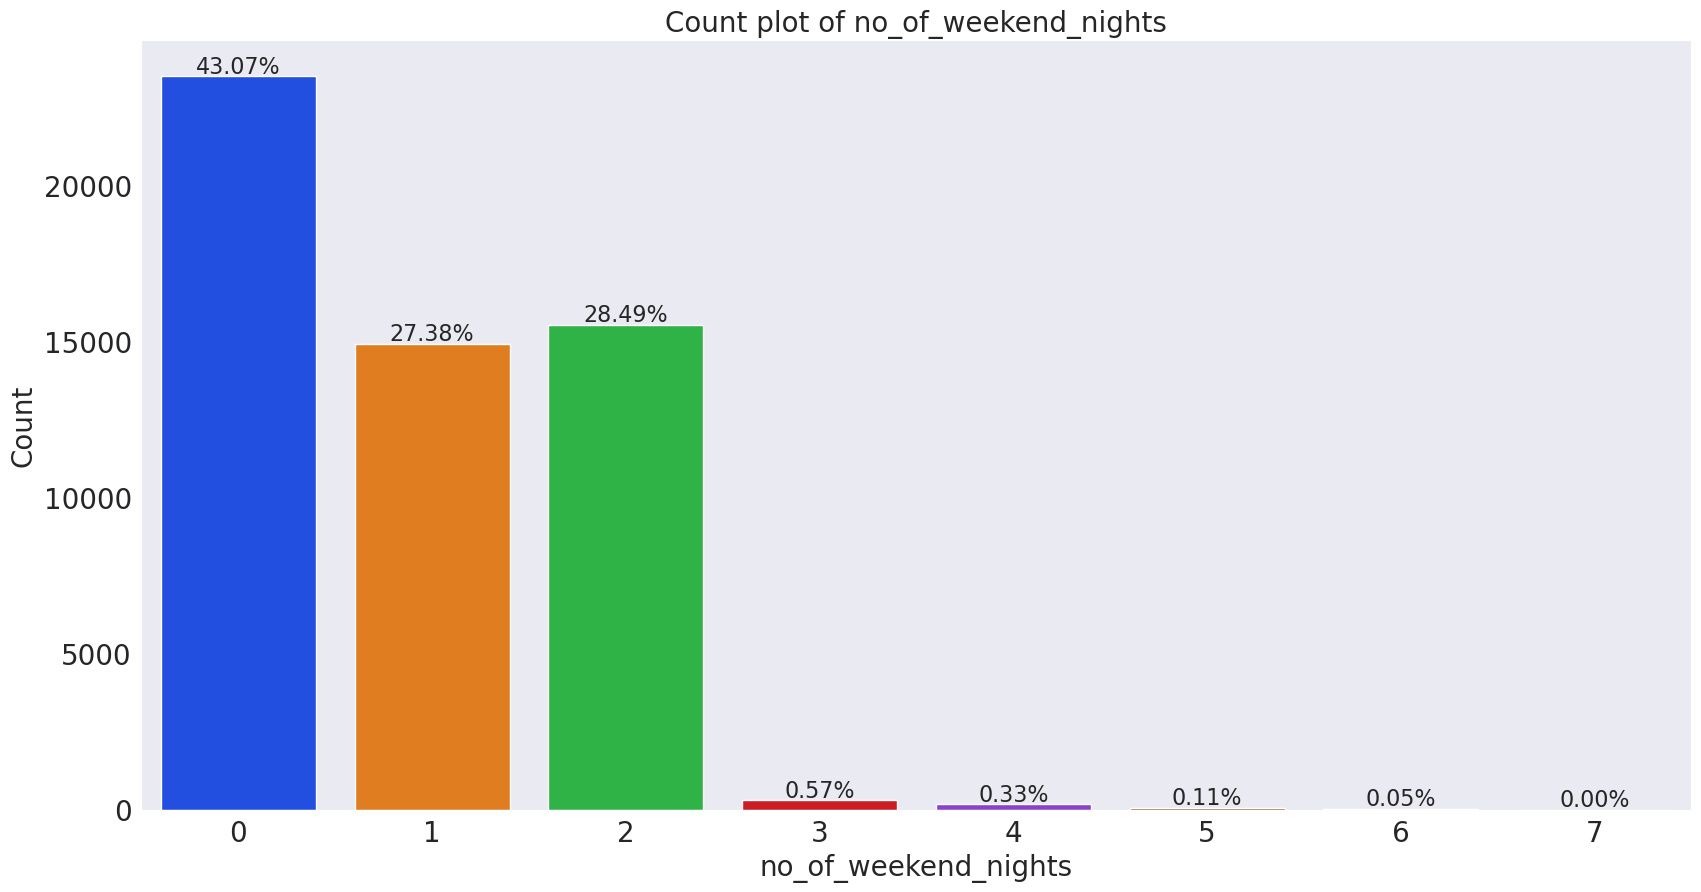

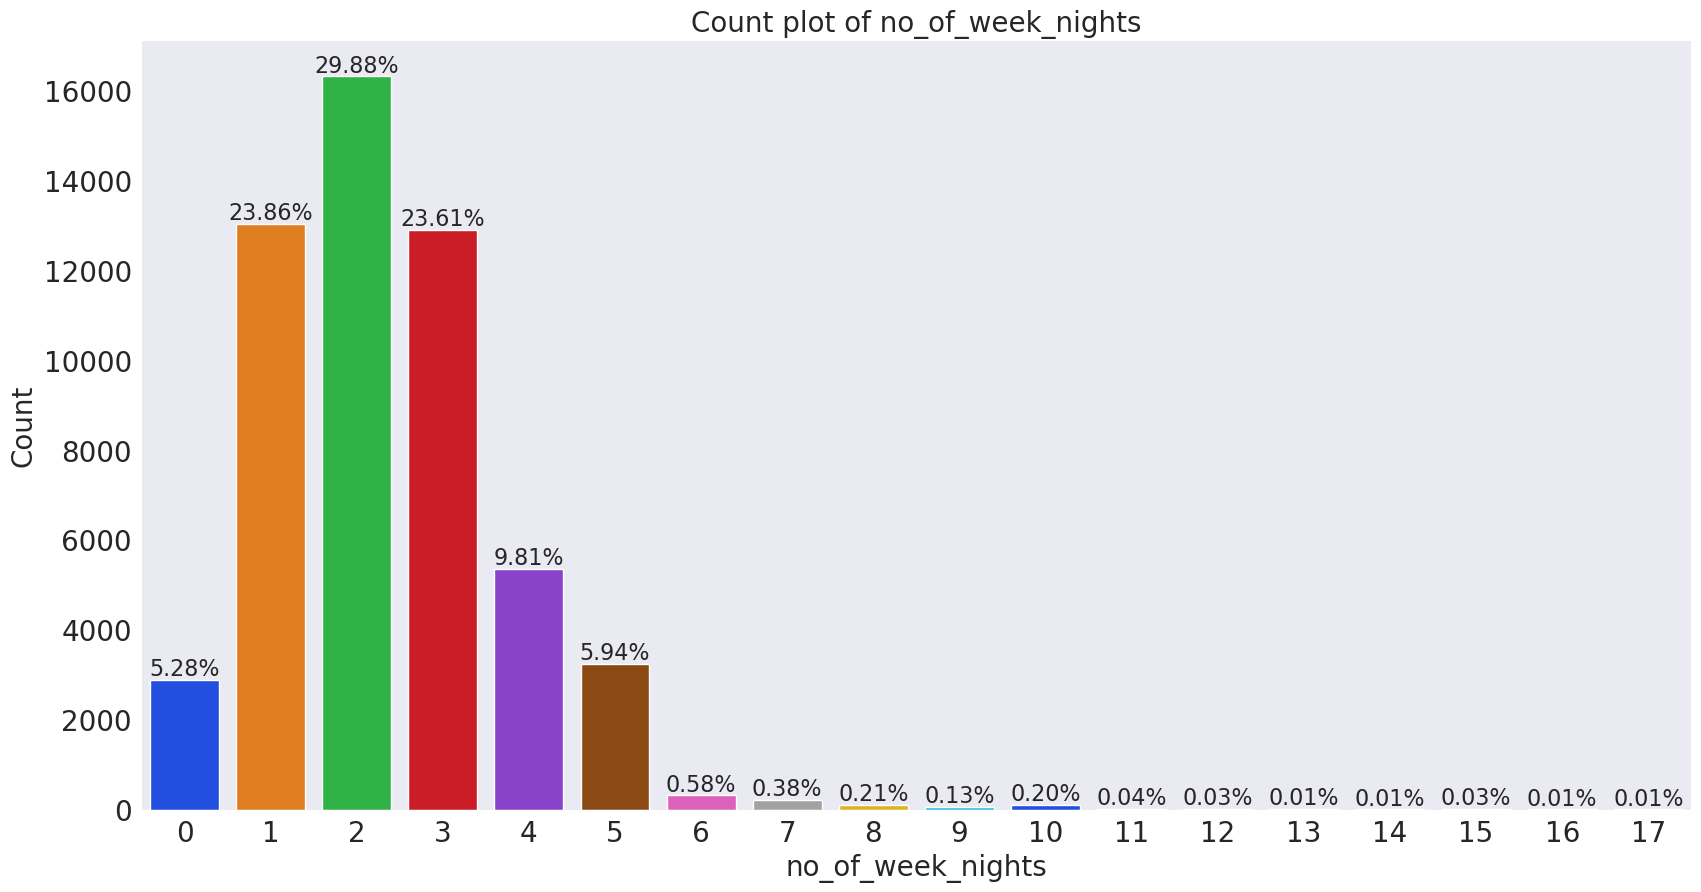

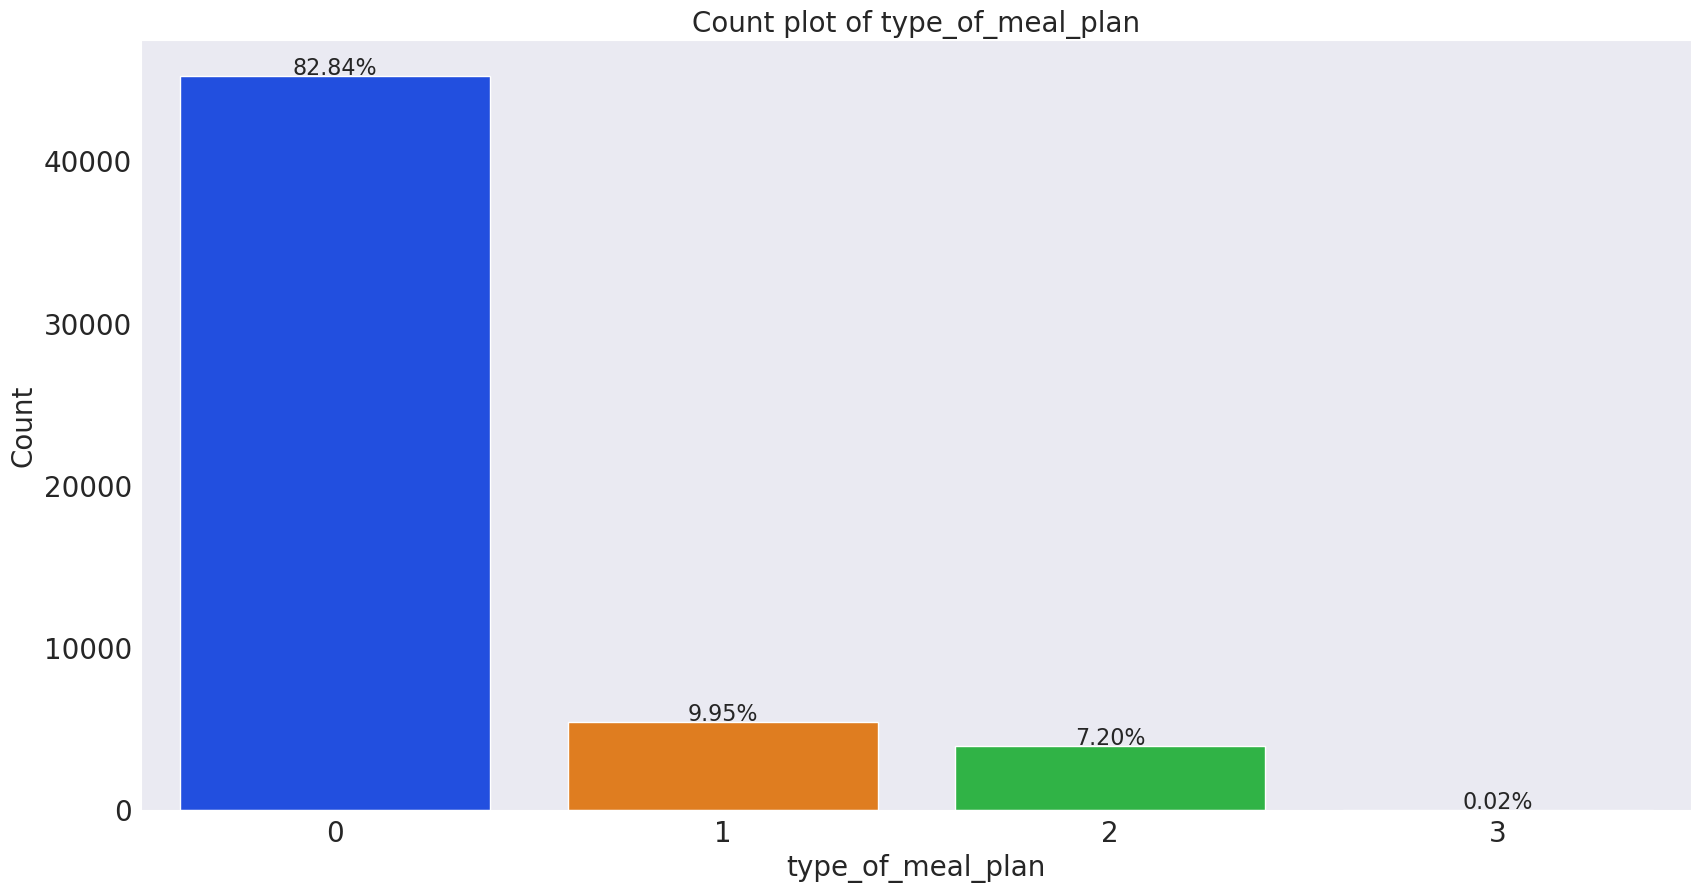

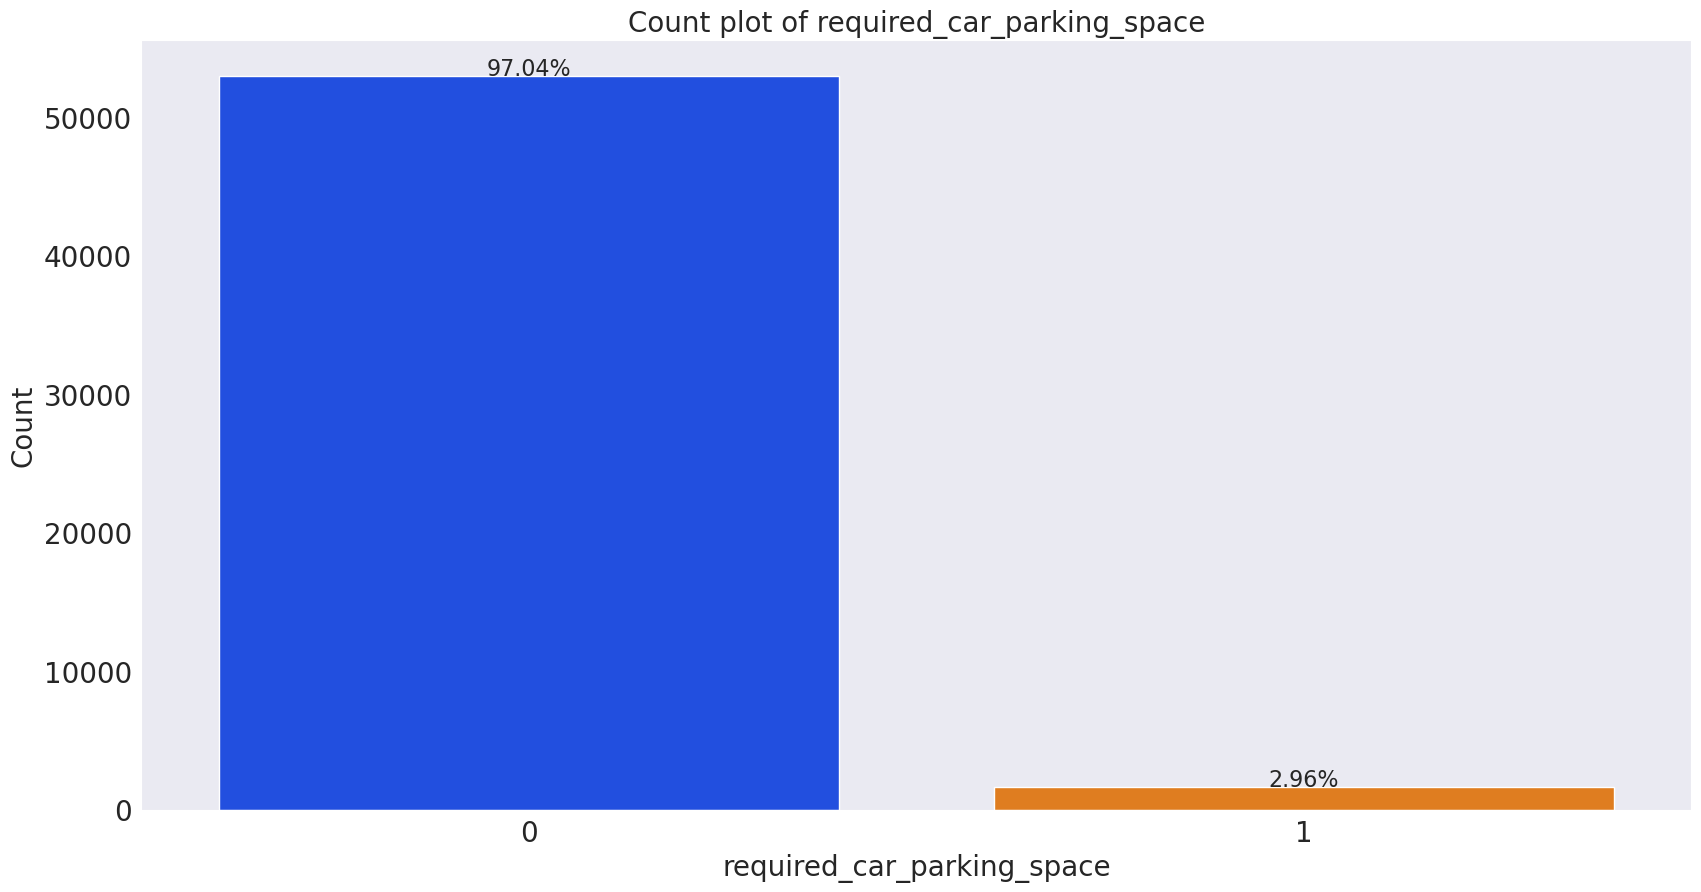

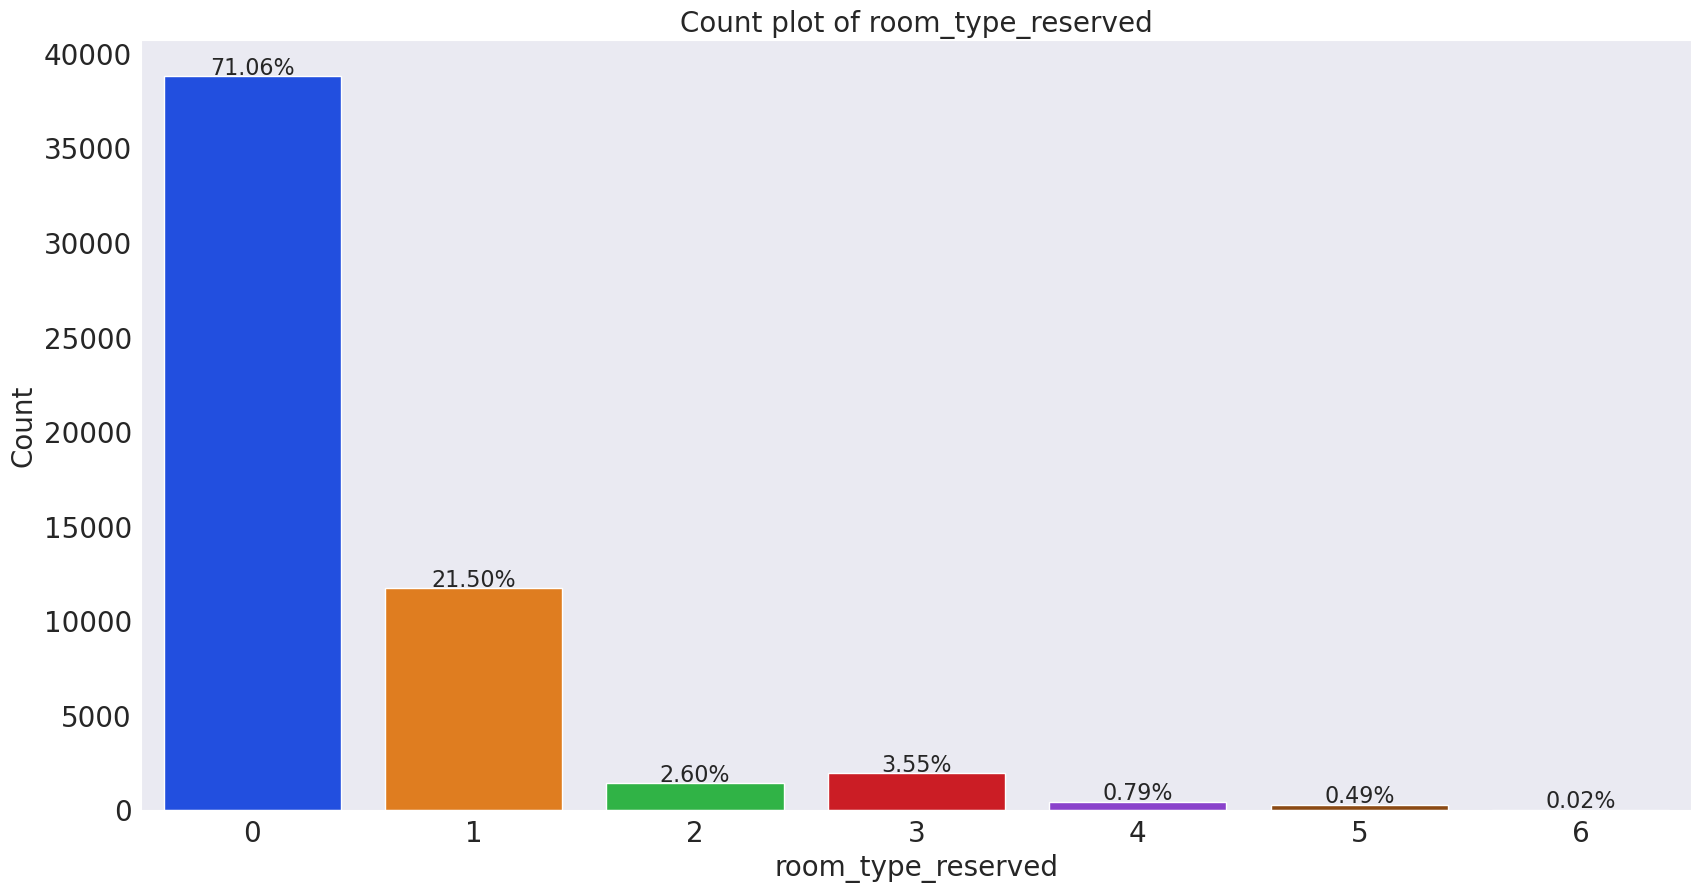

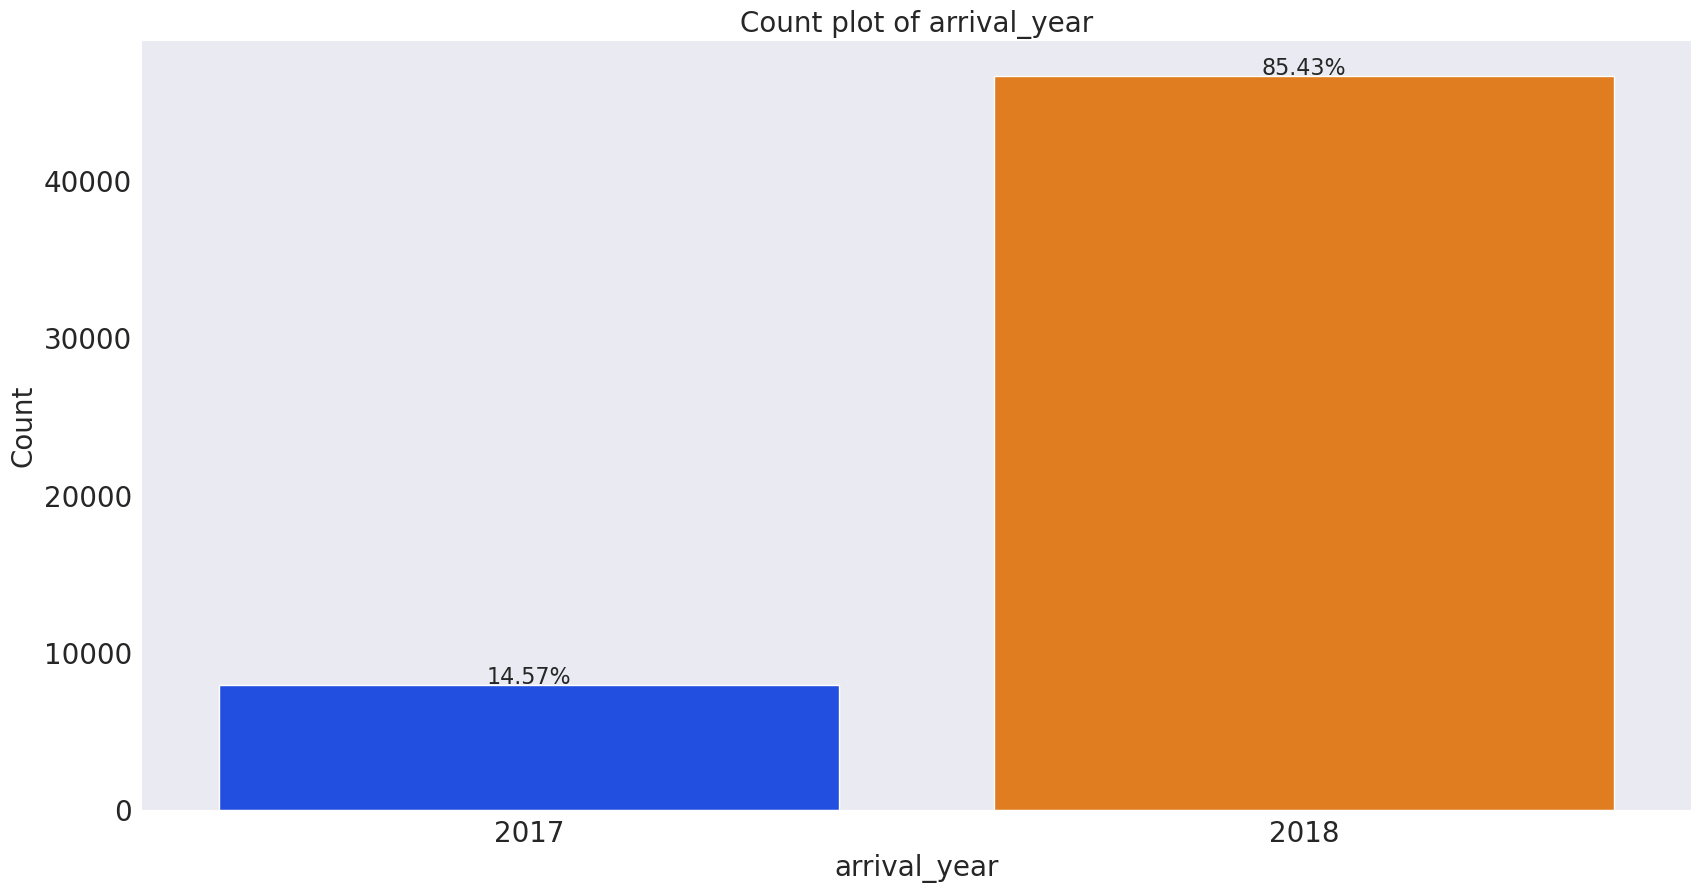

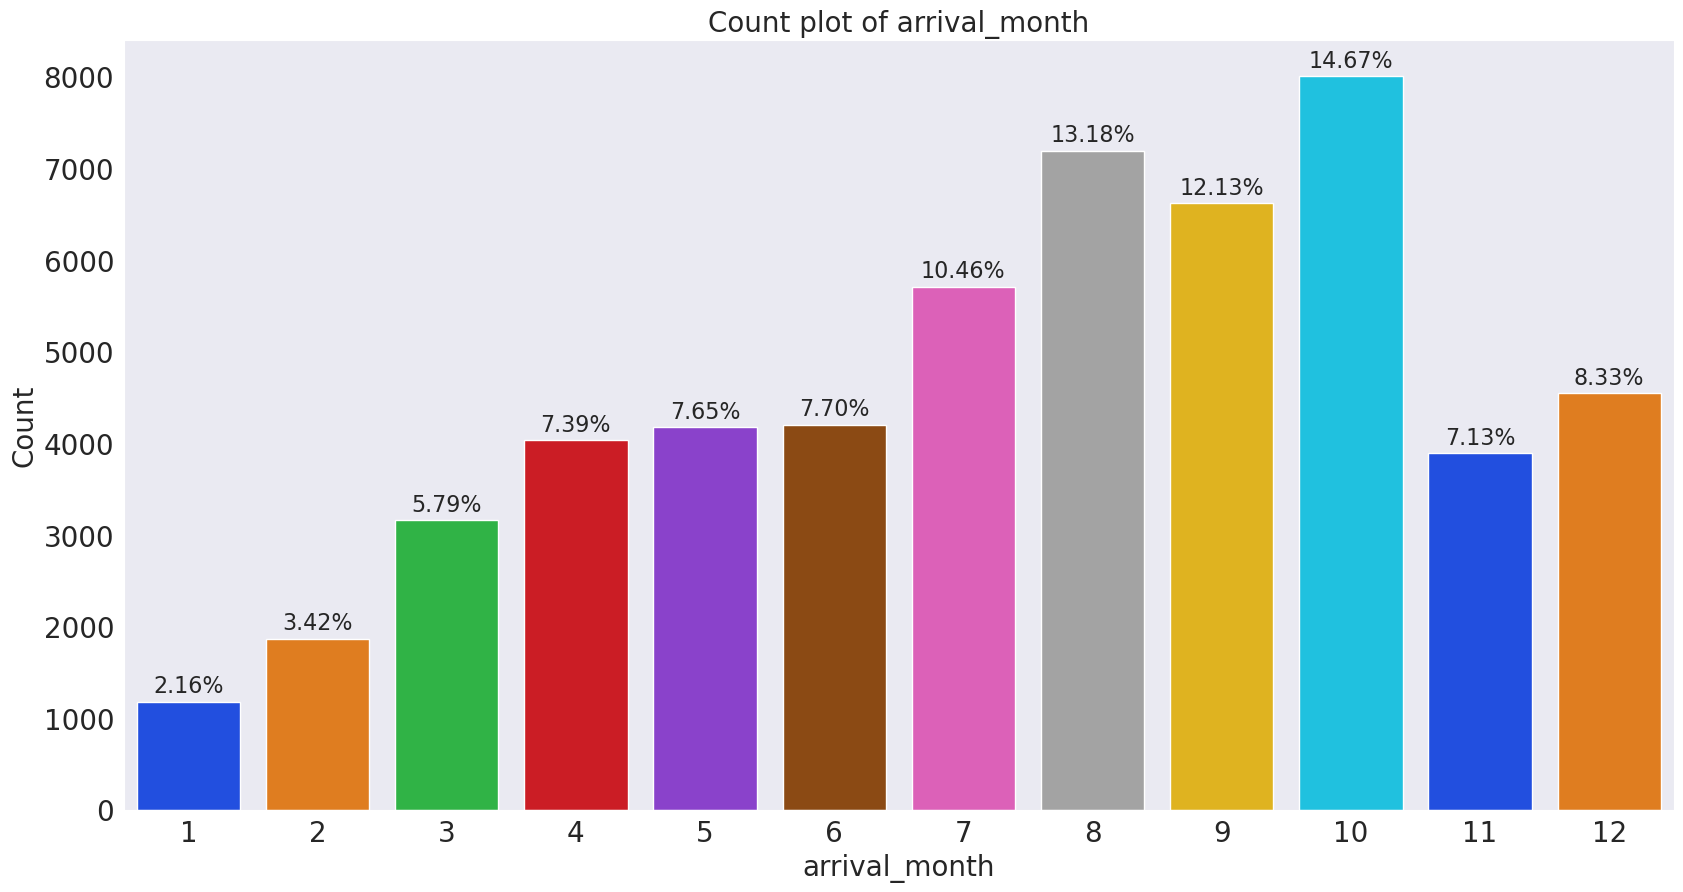

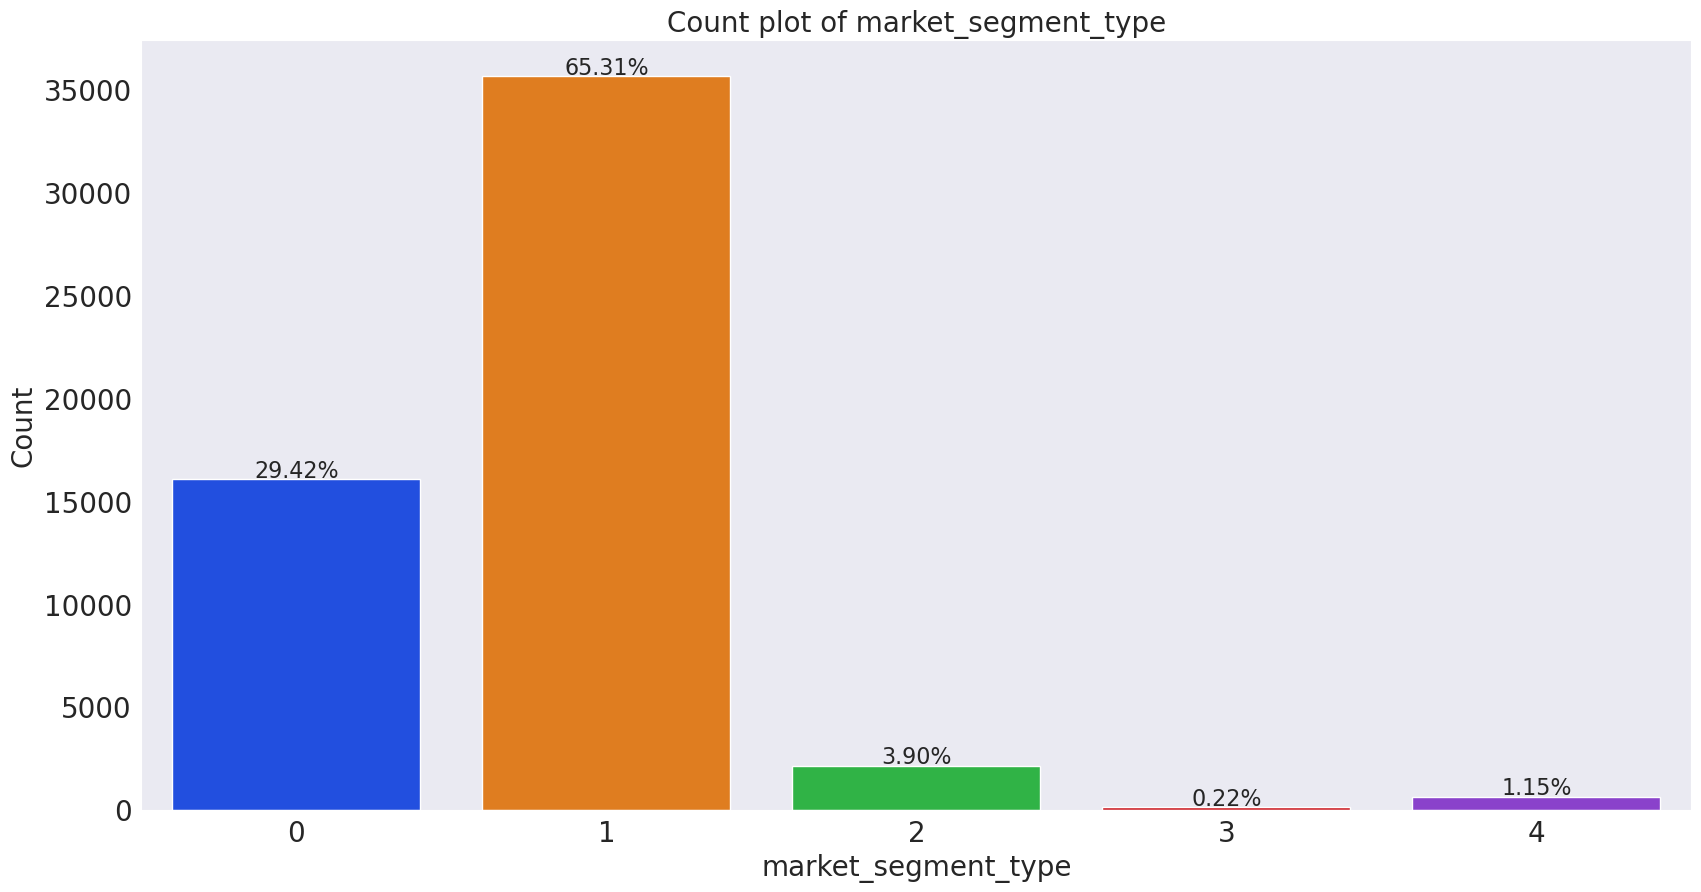

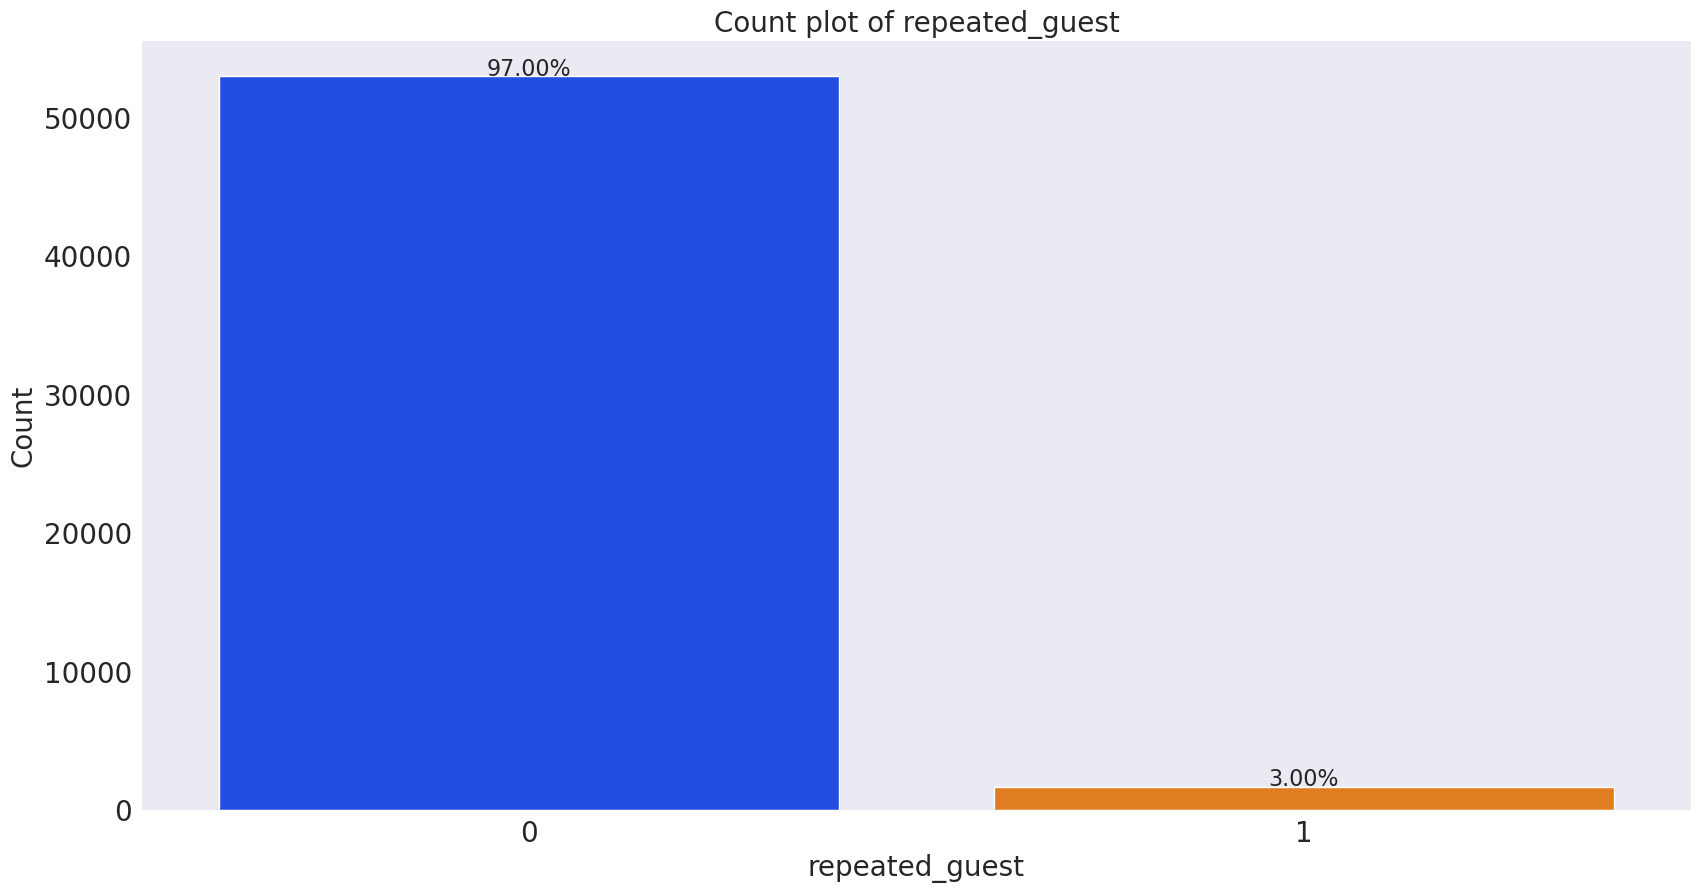

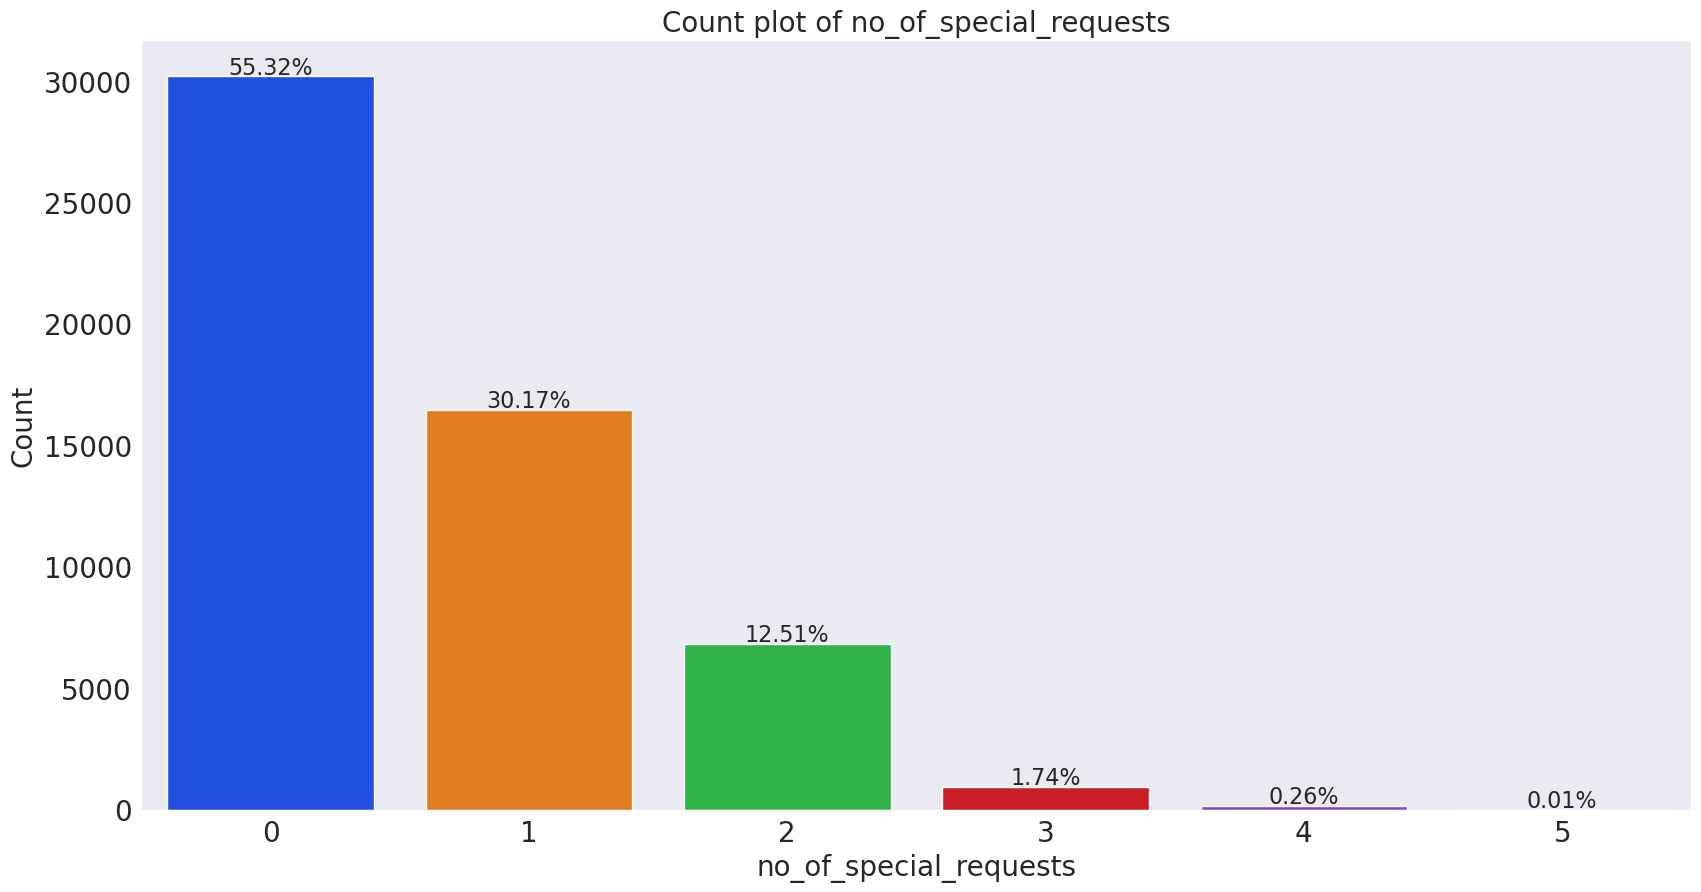

In [10]:
#plotting count plot for the categorical variables to show thier variation
for i in categorical_columns:
    
    plt.figure(figsize=(20,10))
    sns.set_style("dark")
    plot = sns.countplot(data =df_train, x=i,palette='bright')
    
    #adding the percentage of each bar above it
    for bar in plot.patches:
        percentage = '{:.2f}%'.format(100 * bar.get_height()/len(df_train))
        x = bar.get_x() + bar.get_width()/2
        y = bar.get_height()+100
        plot.annotate(percentage, (x, y),ha='center',size=16)
    
    plt.xticks(size=20)
    plt.xlabel(i,size=20)
    plt.yticks(size=20)
    plt.ylabel('Count',size=20)
    plt.title('Count plot of ' + i,size=20)
    plt.show()

## 

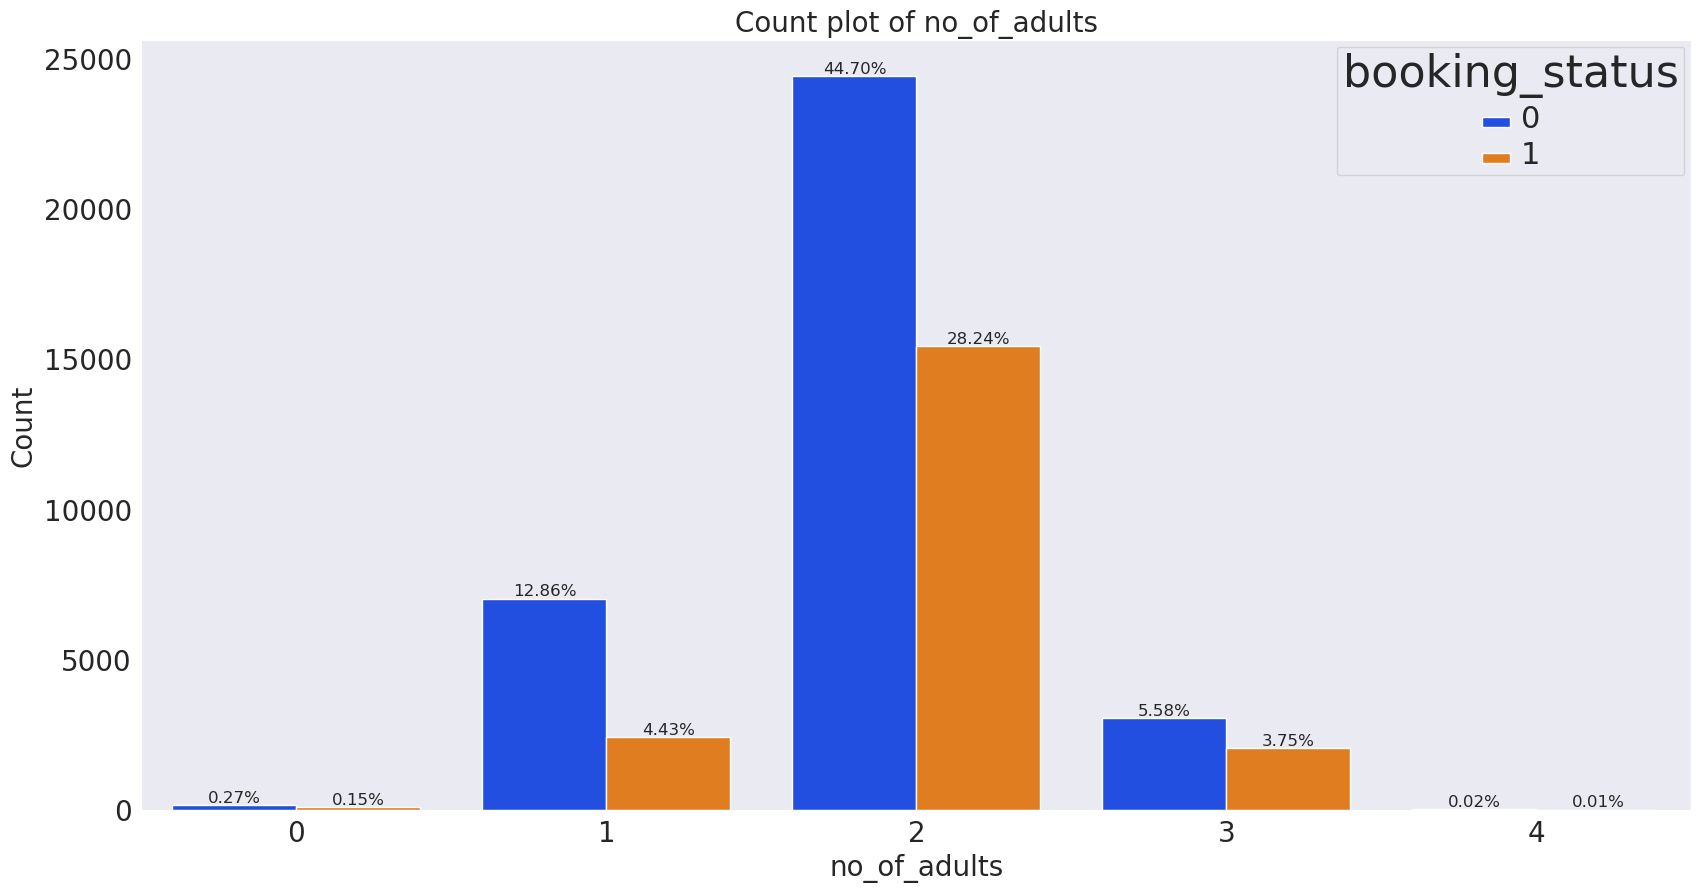

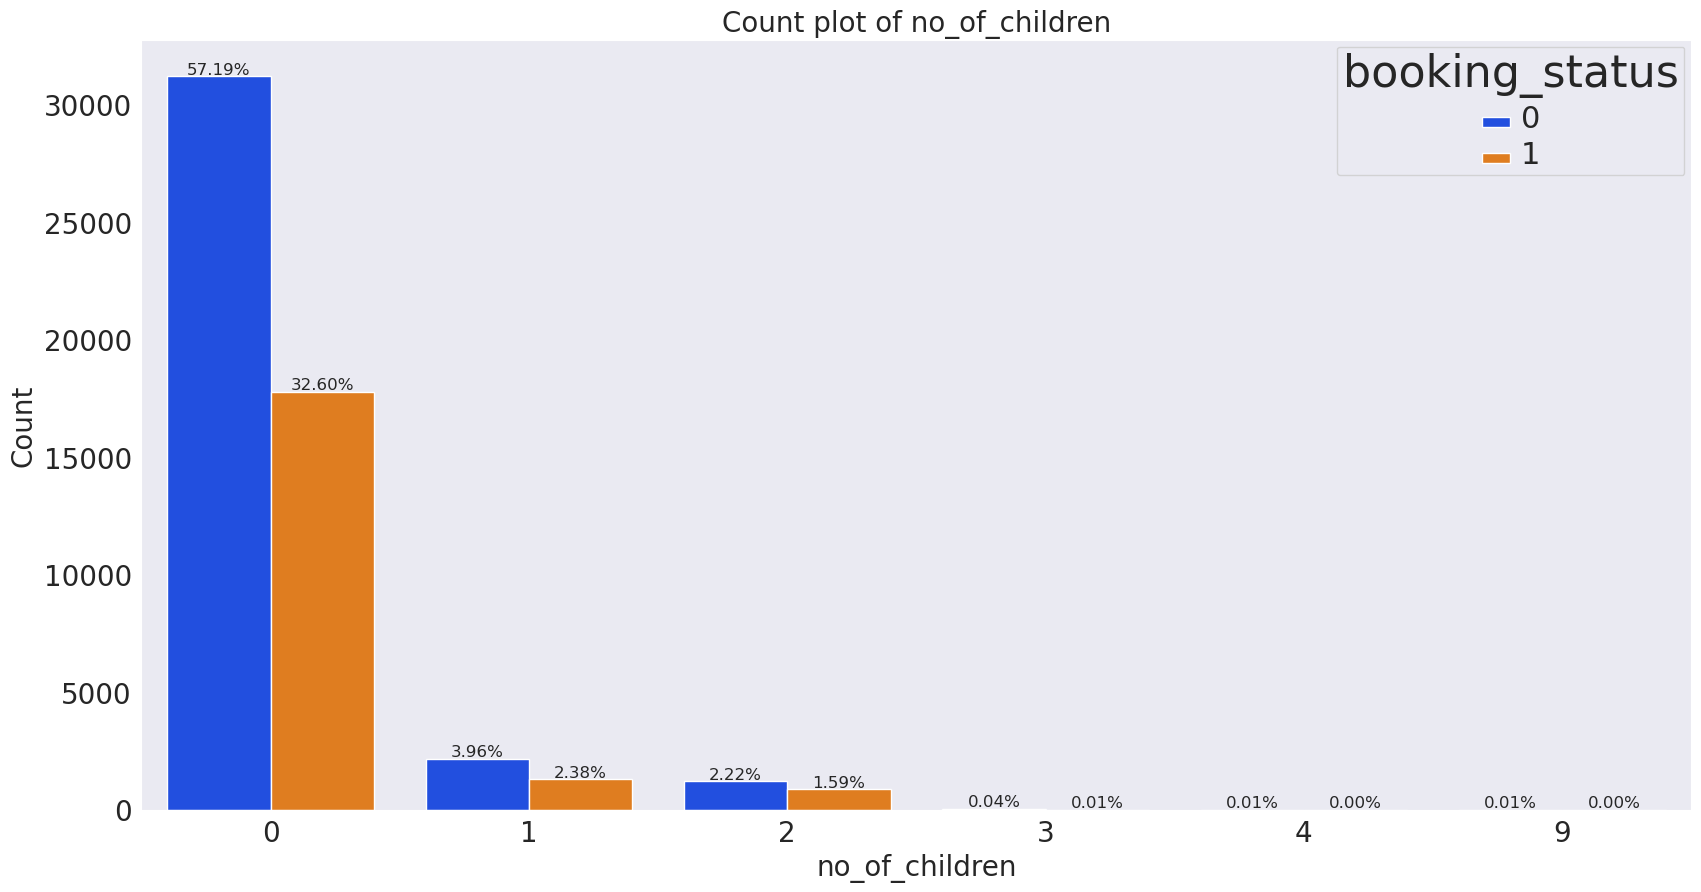

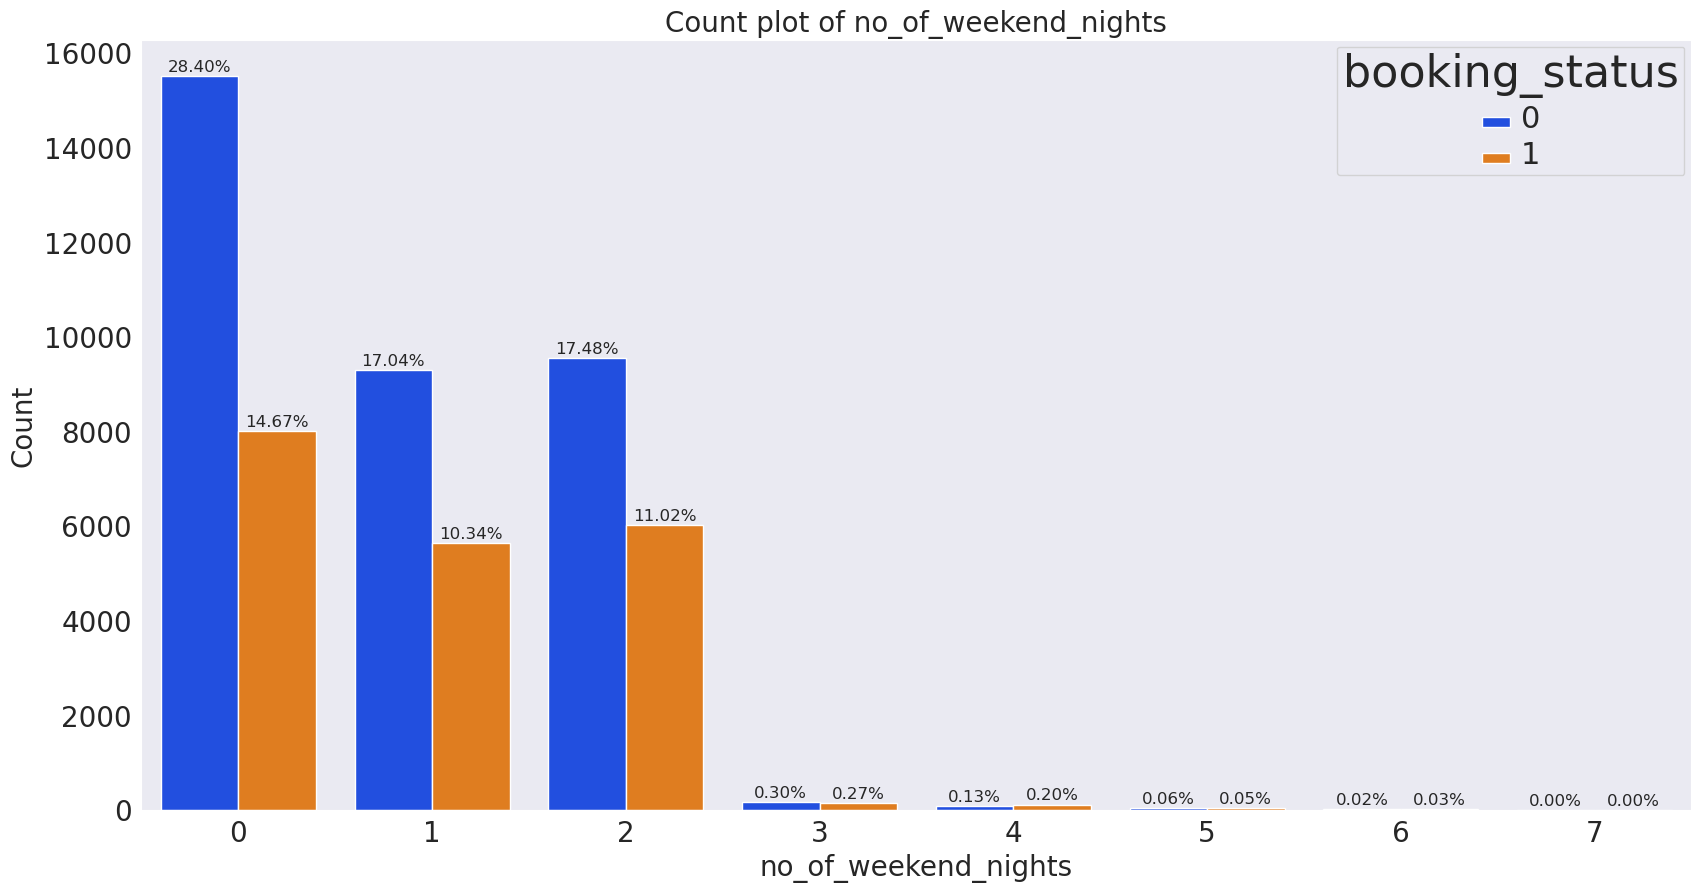

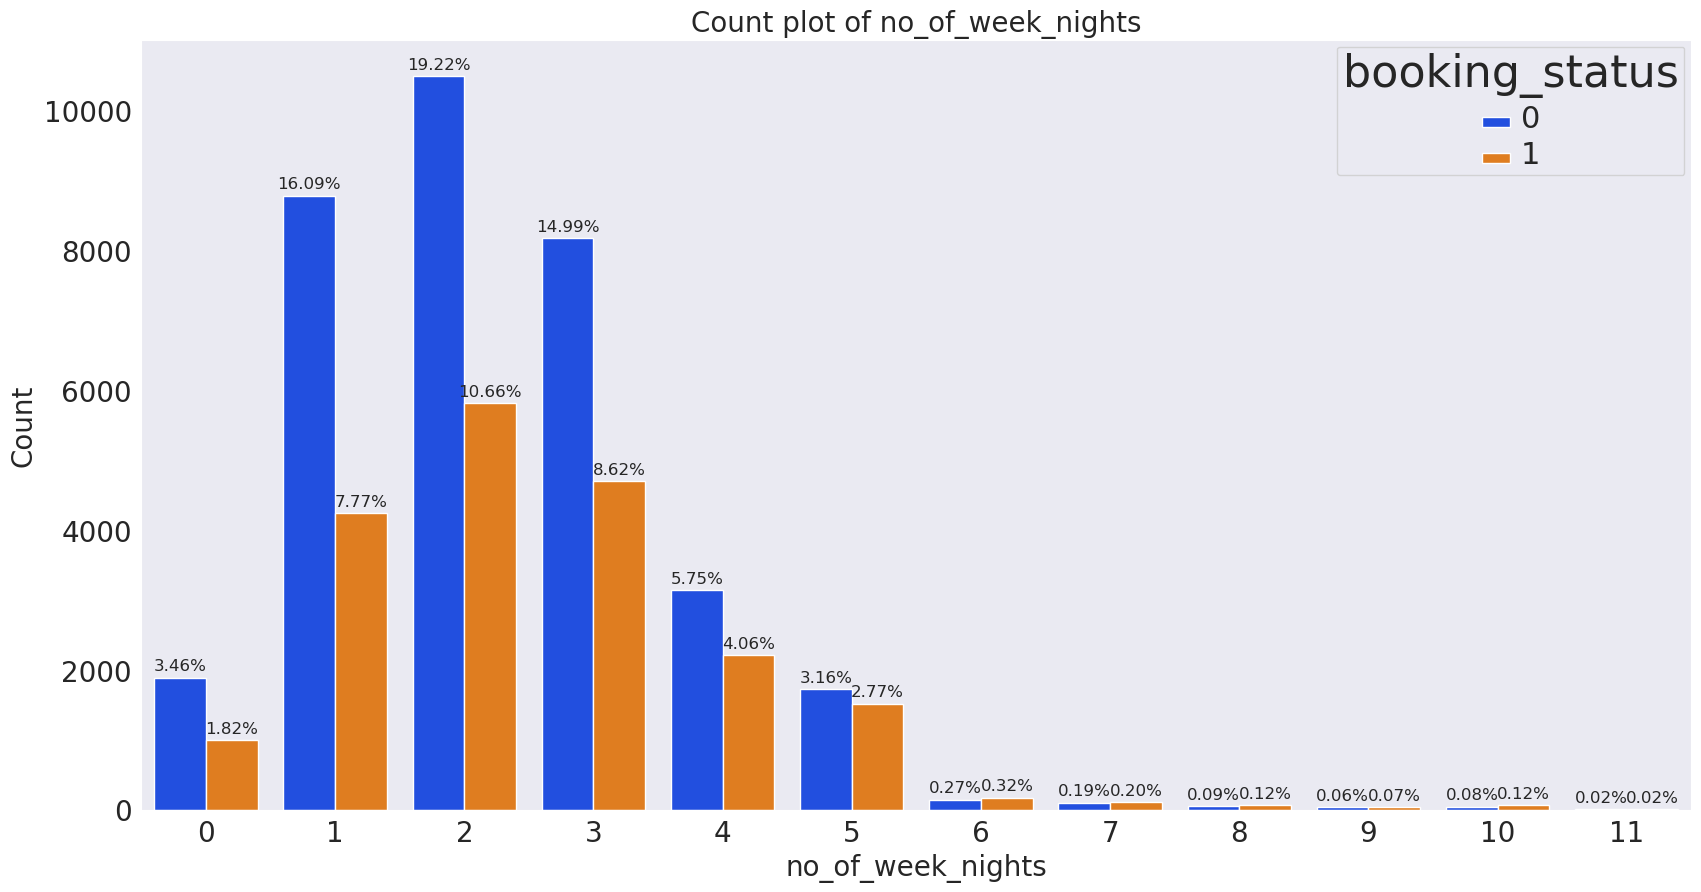

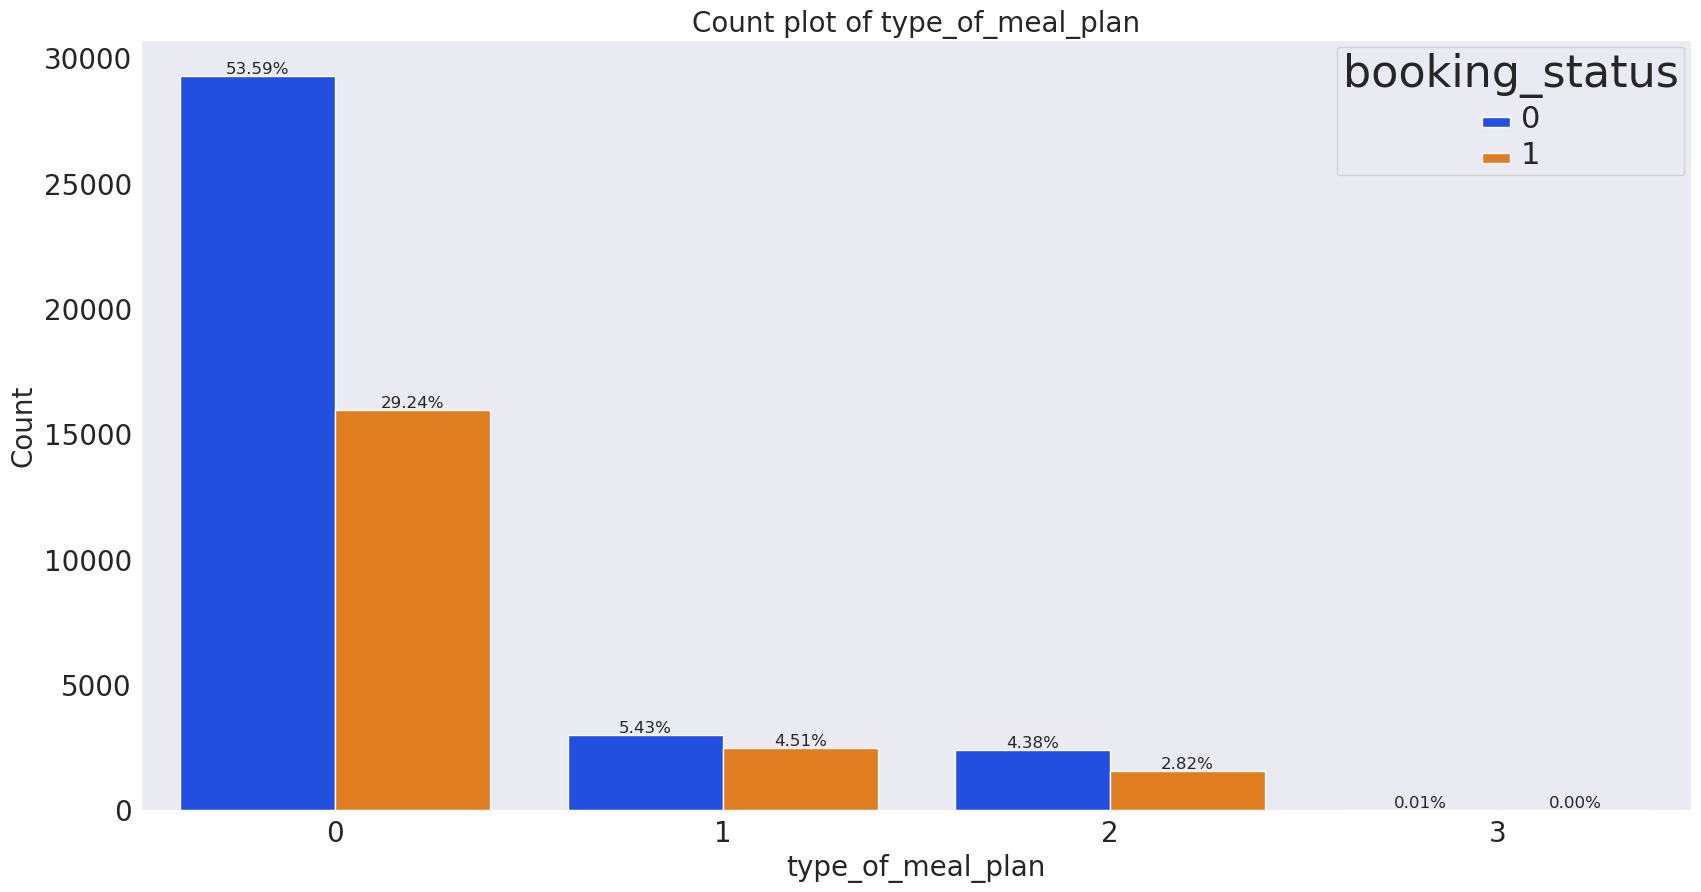

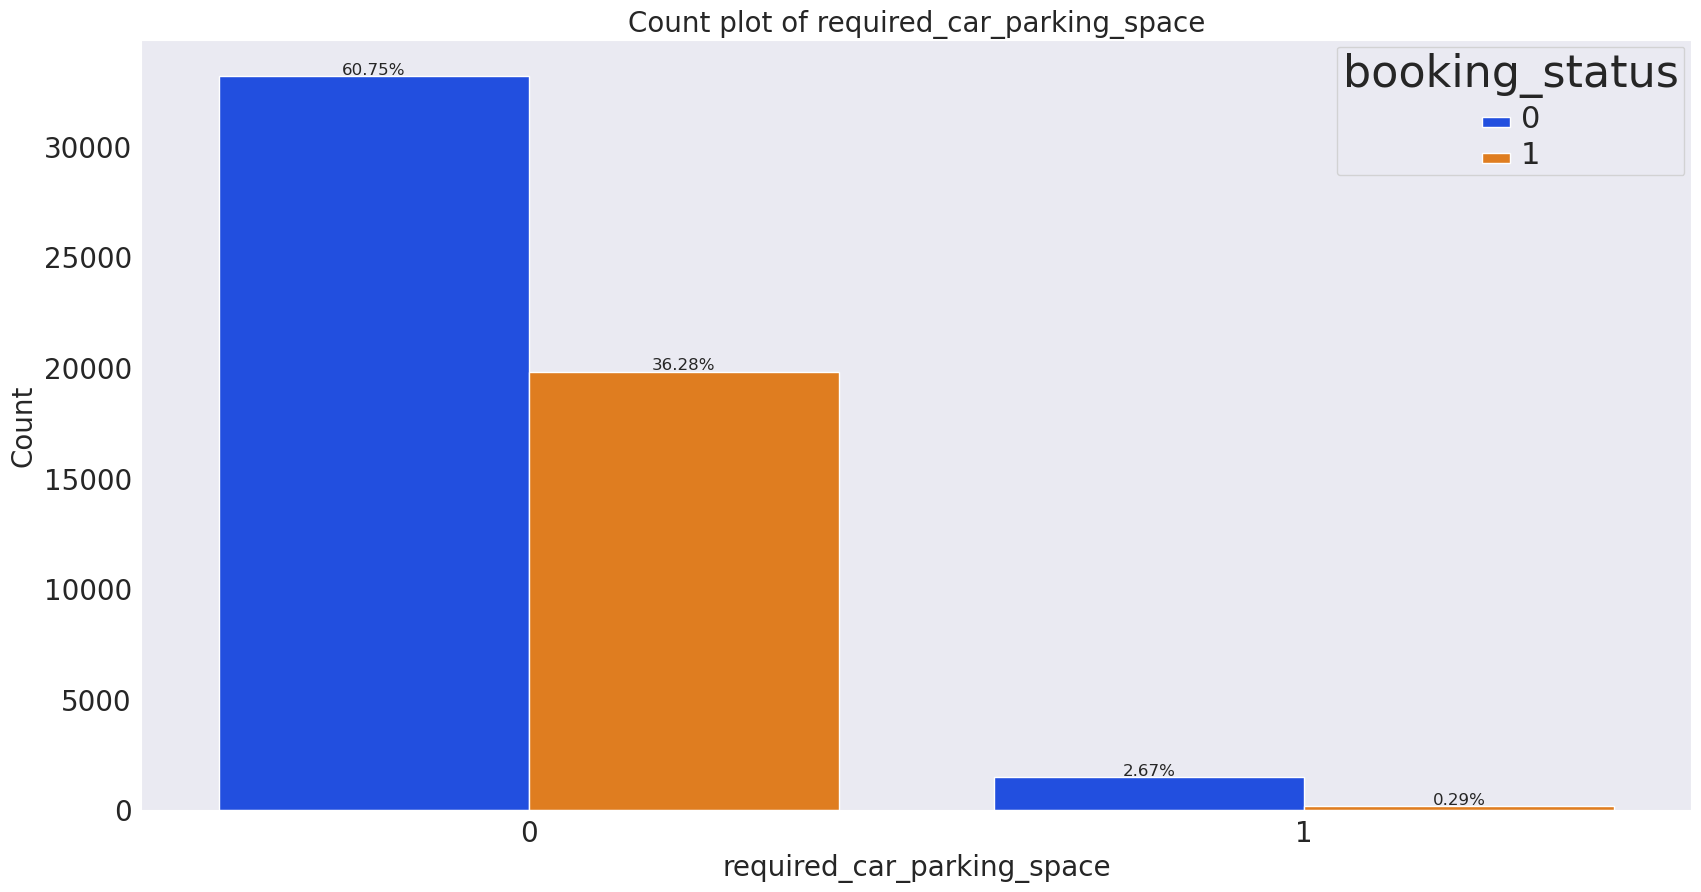

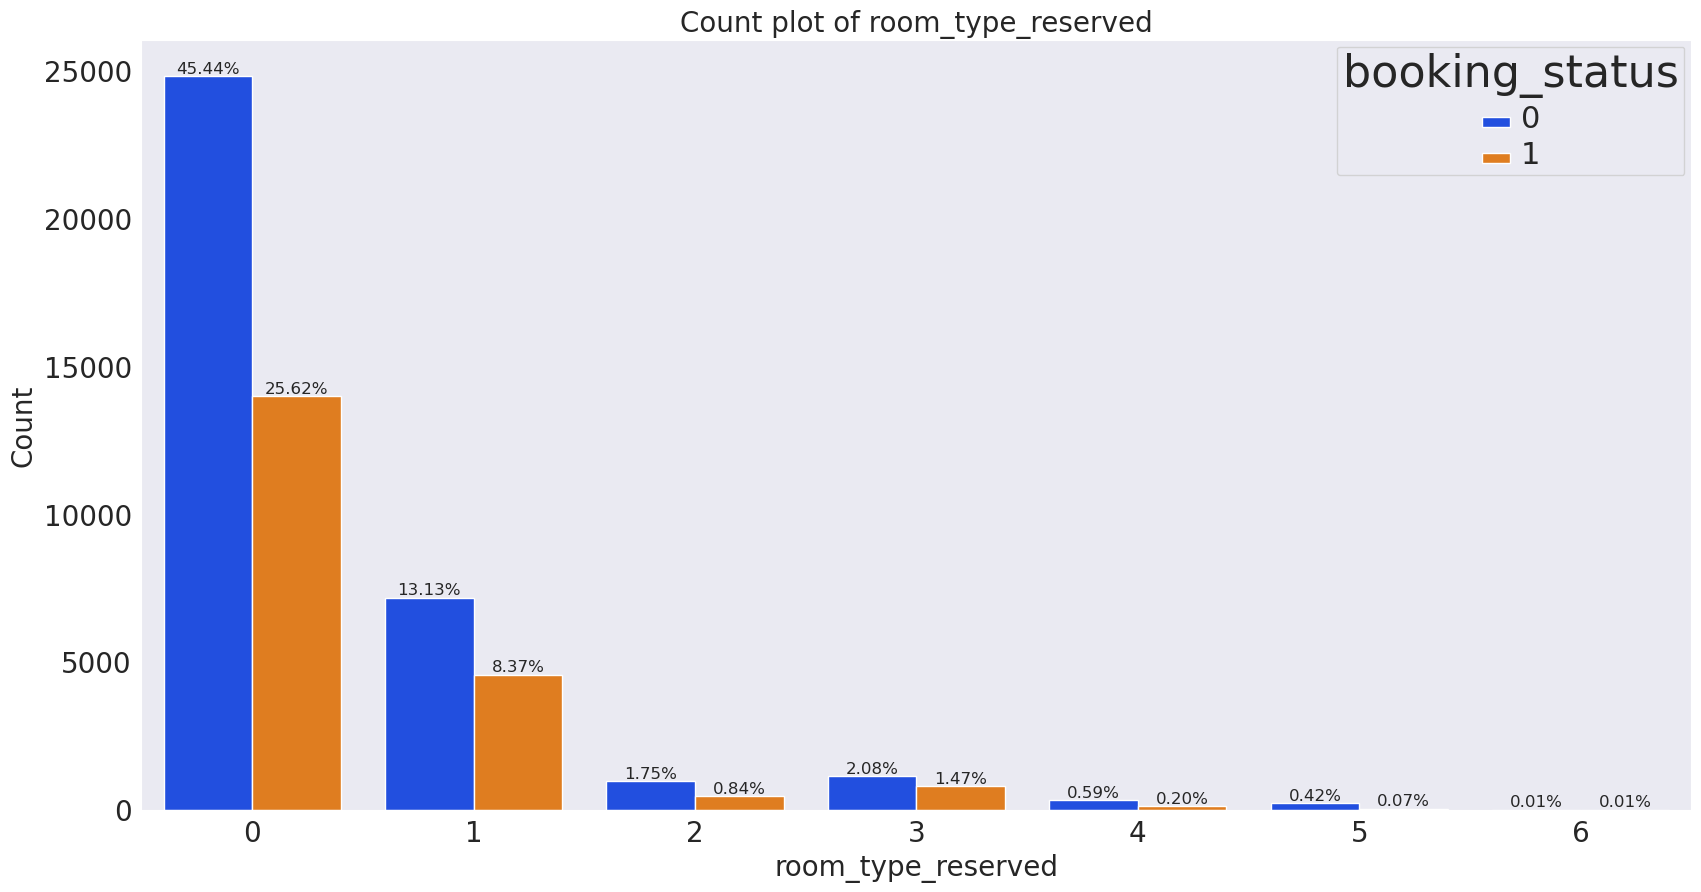

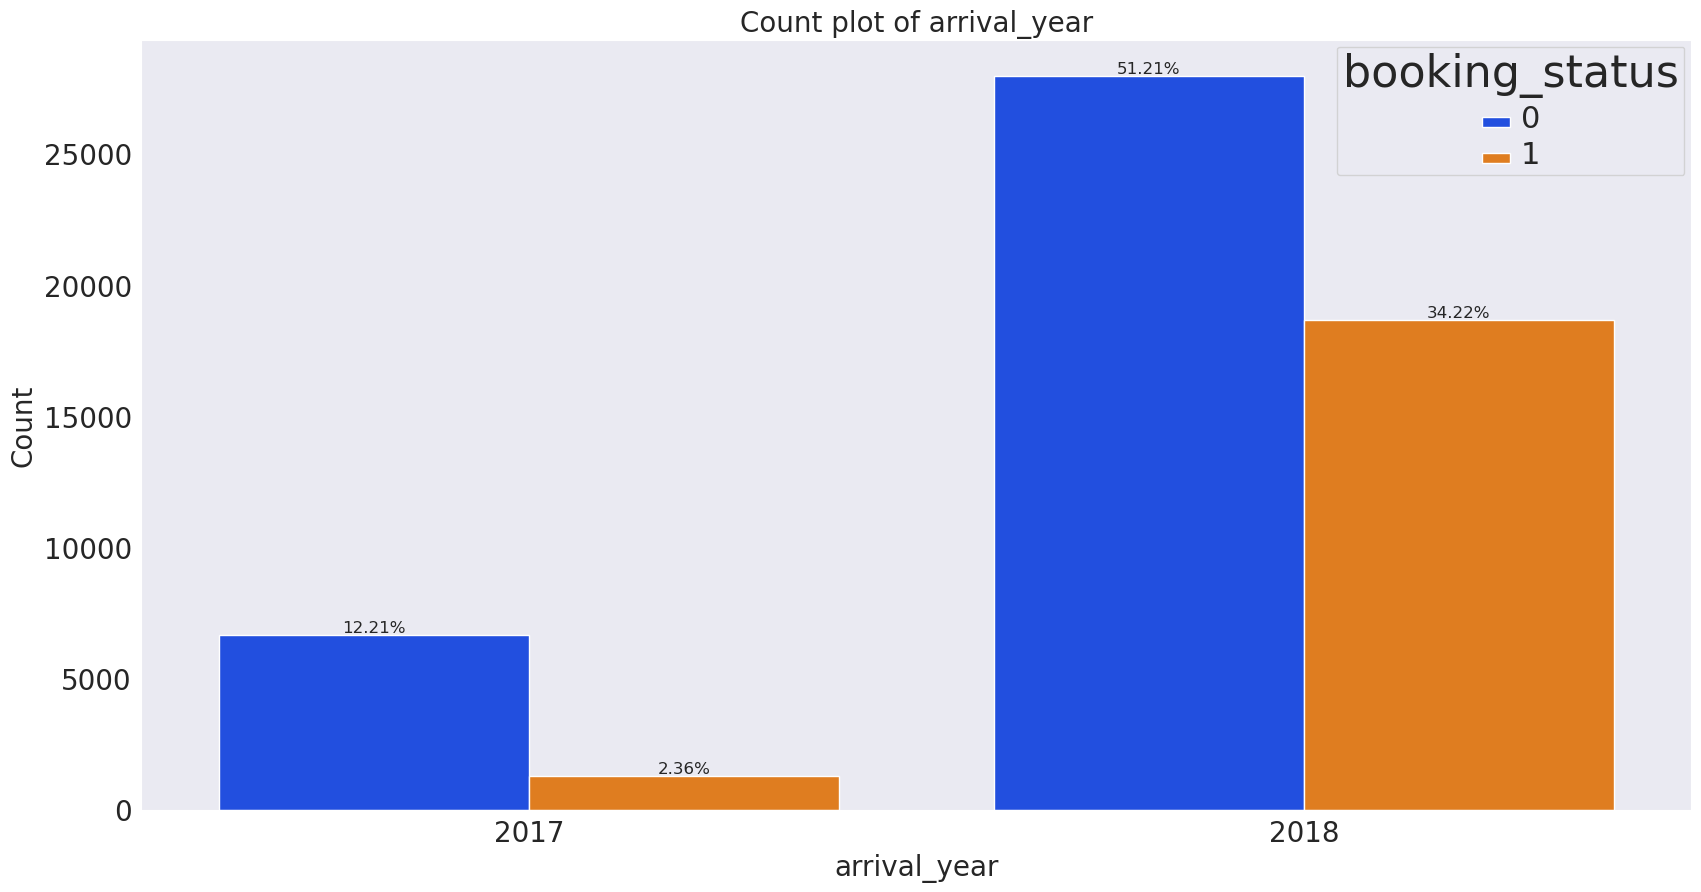

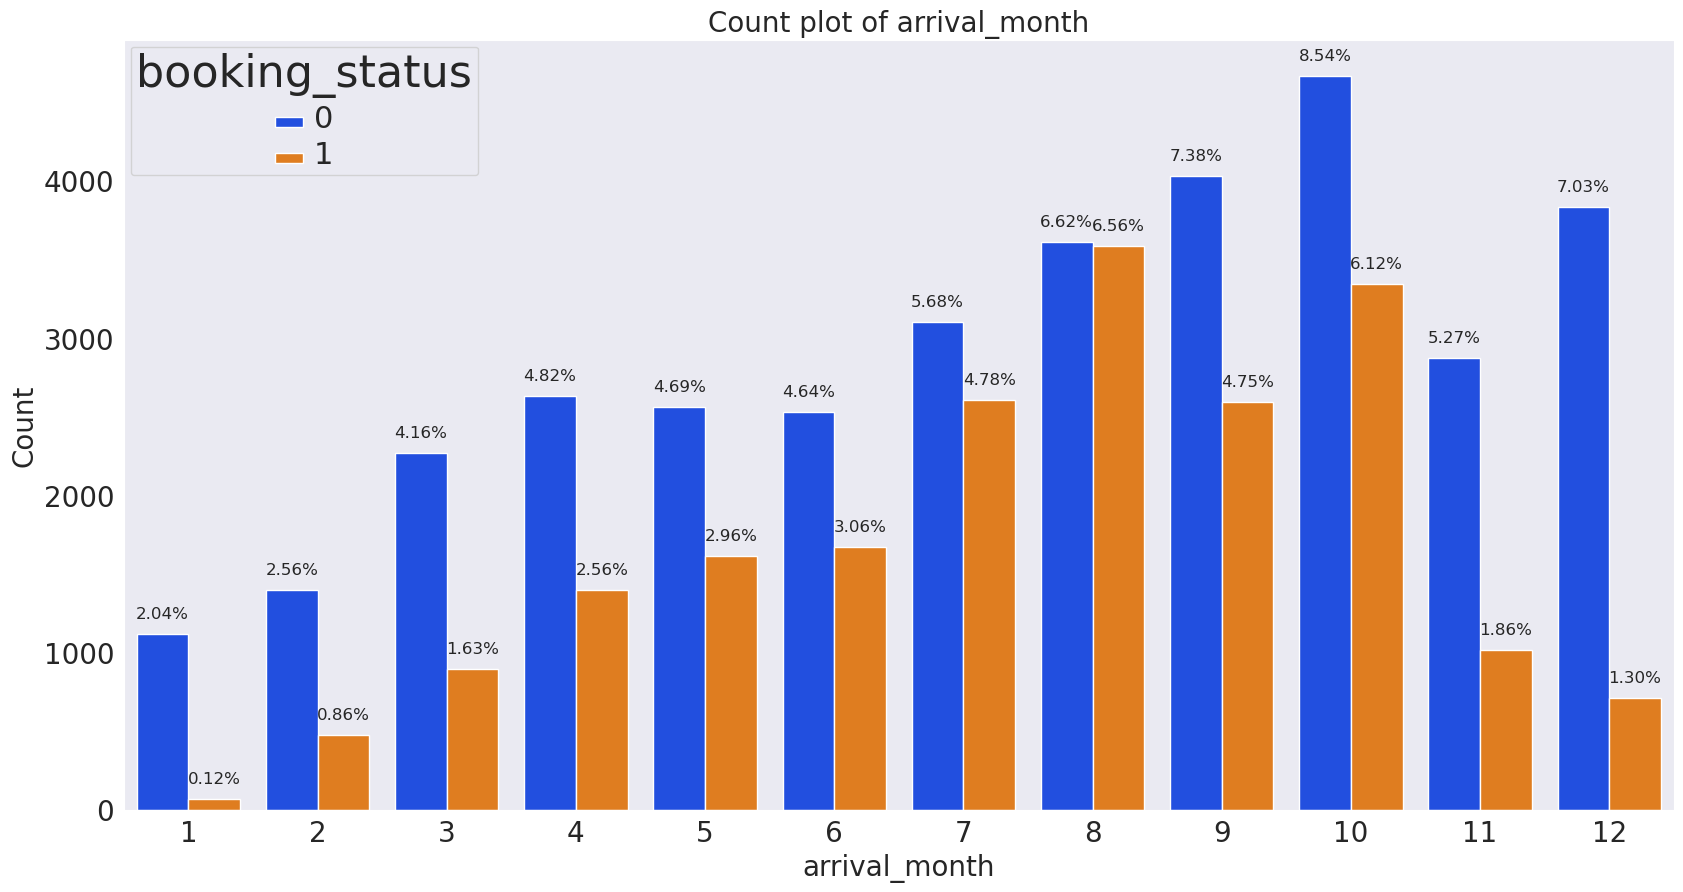

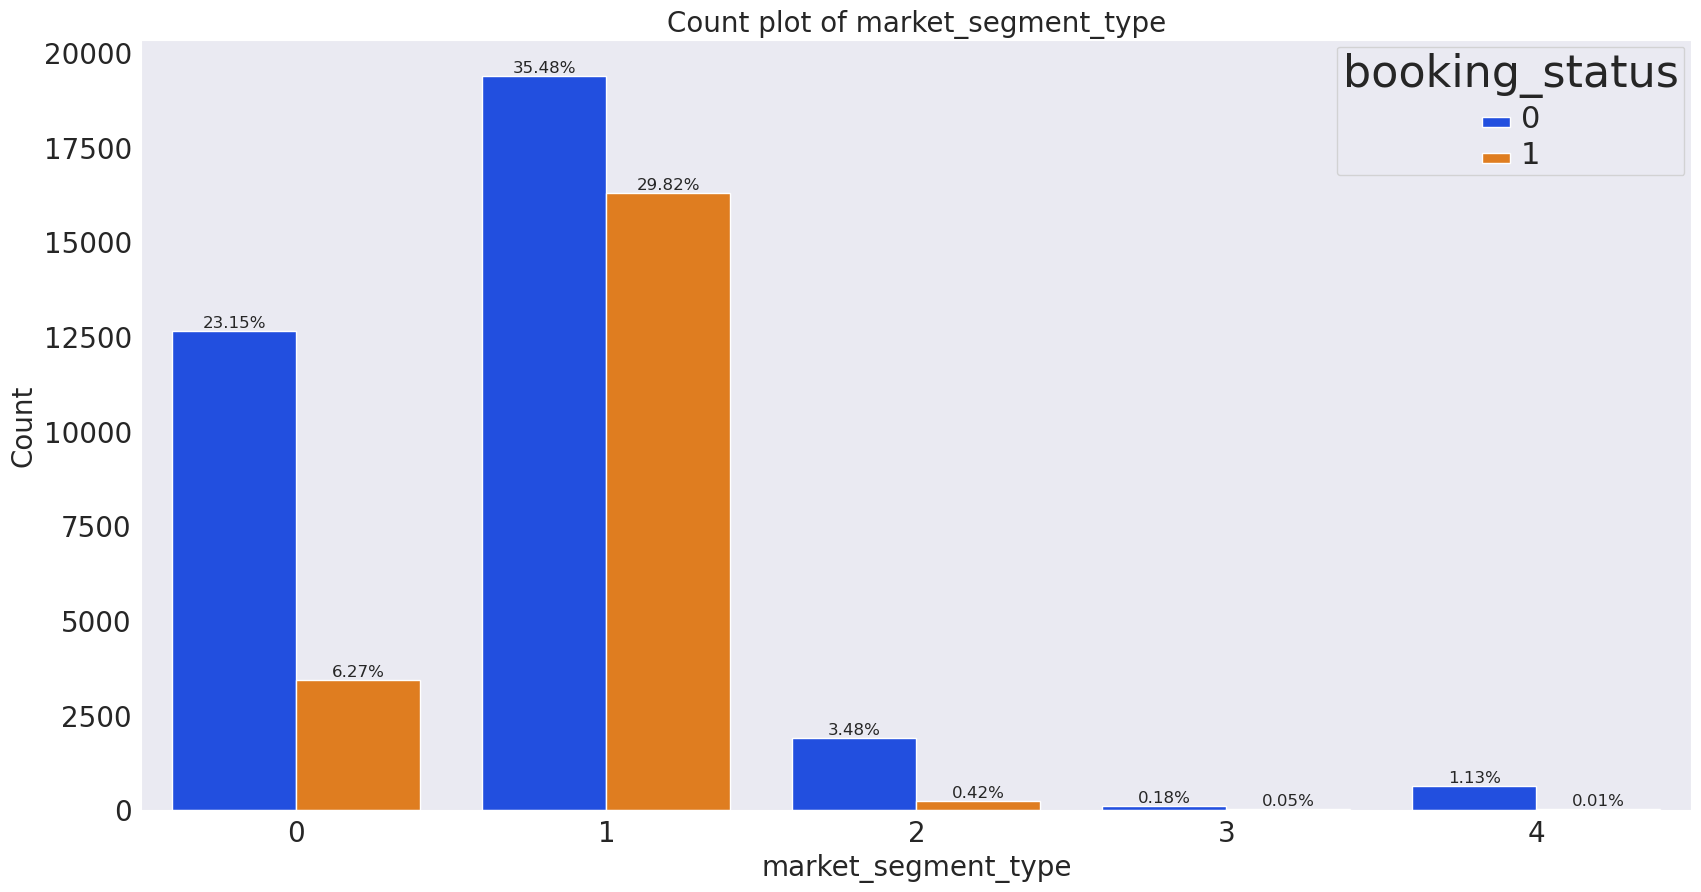

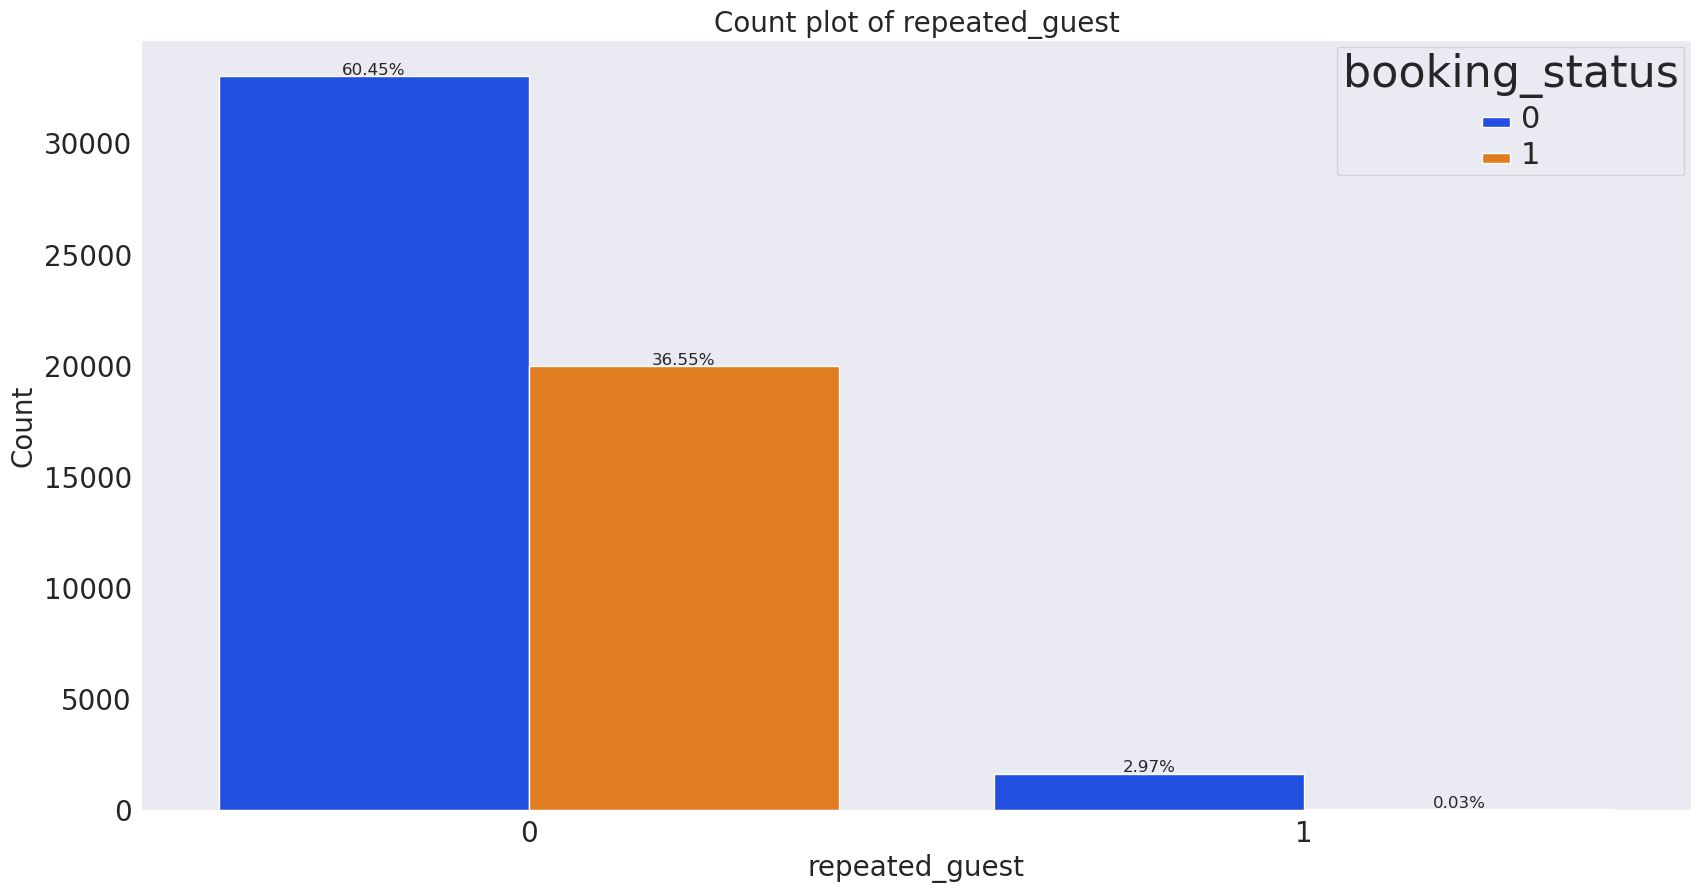

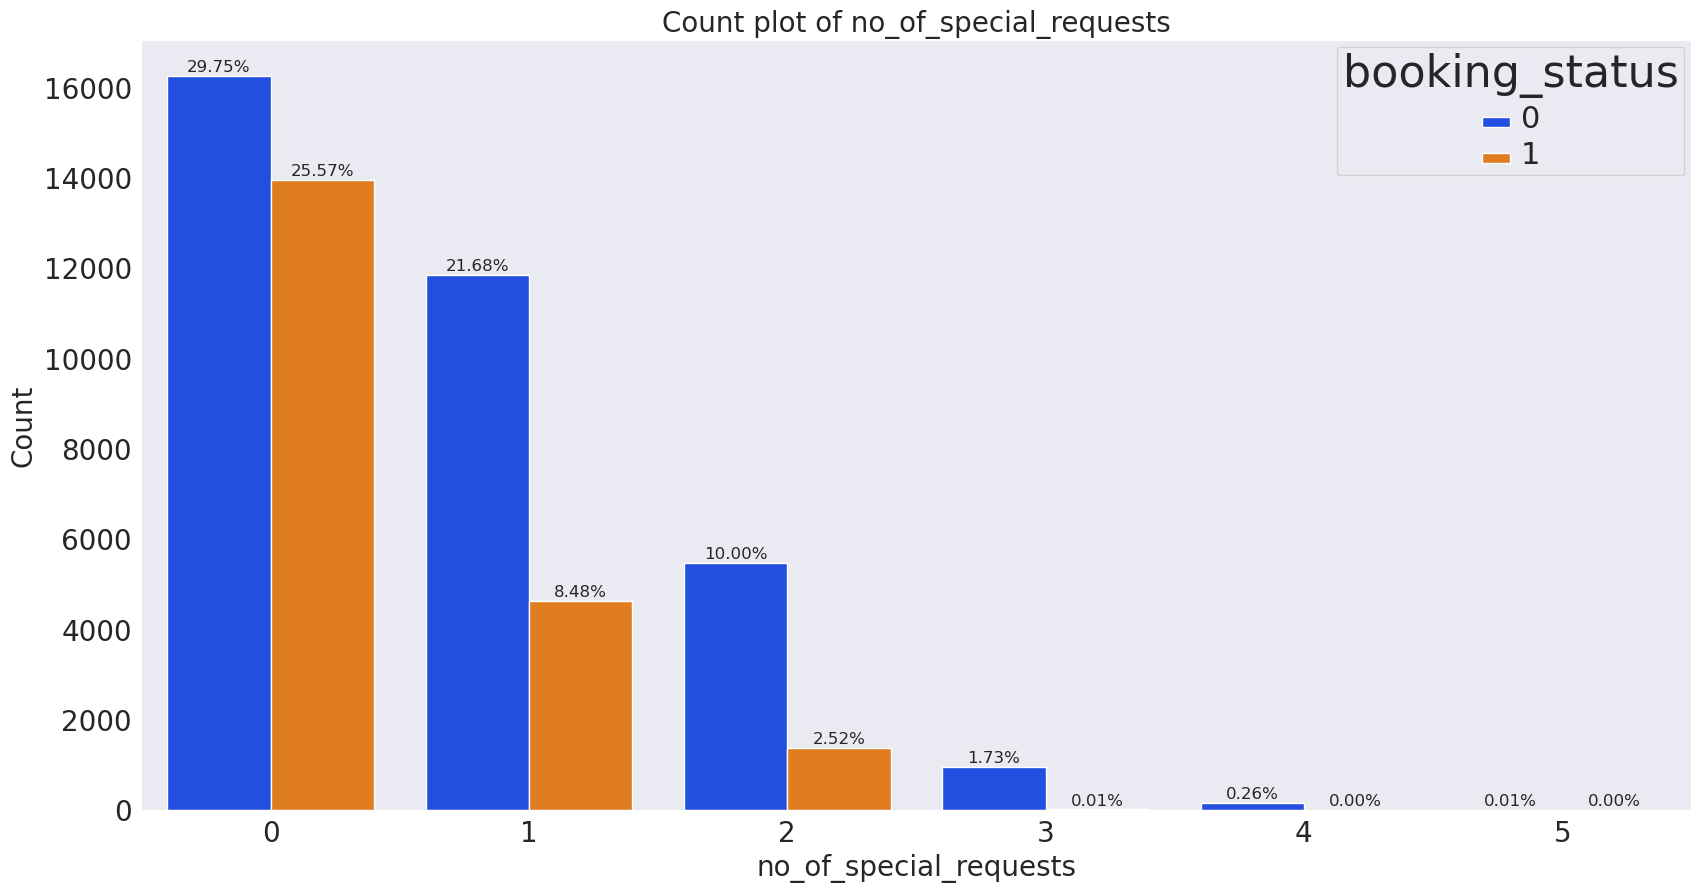

In [11]:
#Doing the same plots but showing how they differ according the target column

for i in categorical_columns:
    
    plt.figure(figsize=(20,10))
    sns.set_style("dark")
    plot = sns.countplot(data =df_train, x=i,hue='booking_status',
                         #this line to limit the plot to the first 8 largest value counts
                         order=df_train[i].value_counts().index[:12].sort_values(),palette='bright')
    
    #adding the percentage of each bar above it
    for bar in plot.patches:
        percentage = '{:.2f}%'.format(100 * bar.get_height()/len(df_train))
        x = bar.get_x() + bar.get_width()/2
        y = bar.get_height()+100
        plot.annotate(percentage, (x, y),ha='center',size=12)
    
    plt.xticks(size=20)
    plt.xlabel(i,size=20)
    plt.yticks(size=20)
    plt.ylabel('Count',size=20)
    plt.title('Count plot of ' + i,size=20)
    plt.setp(plot.get_legend().get_texts(), size=22) # for legend text
    plt.setp(plot.get_legend().get_title(), size=32) # for legend title
    plt.show()

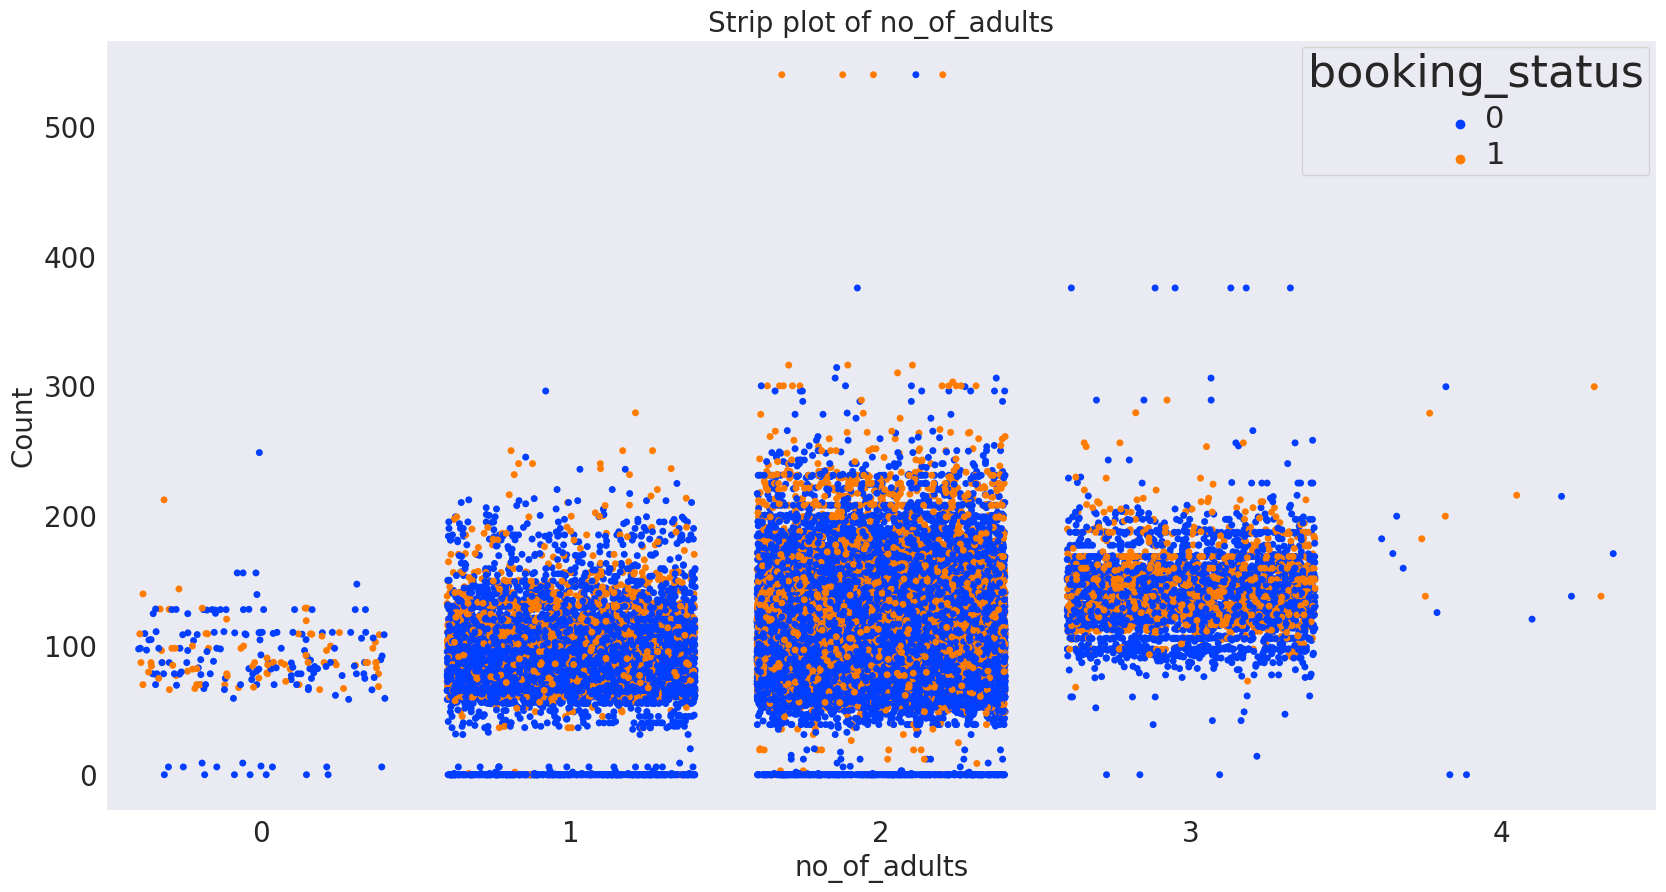

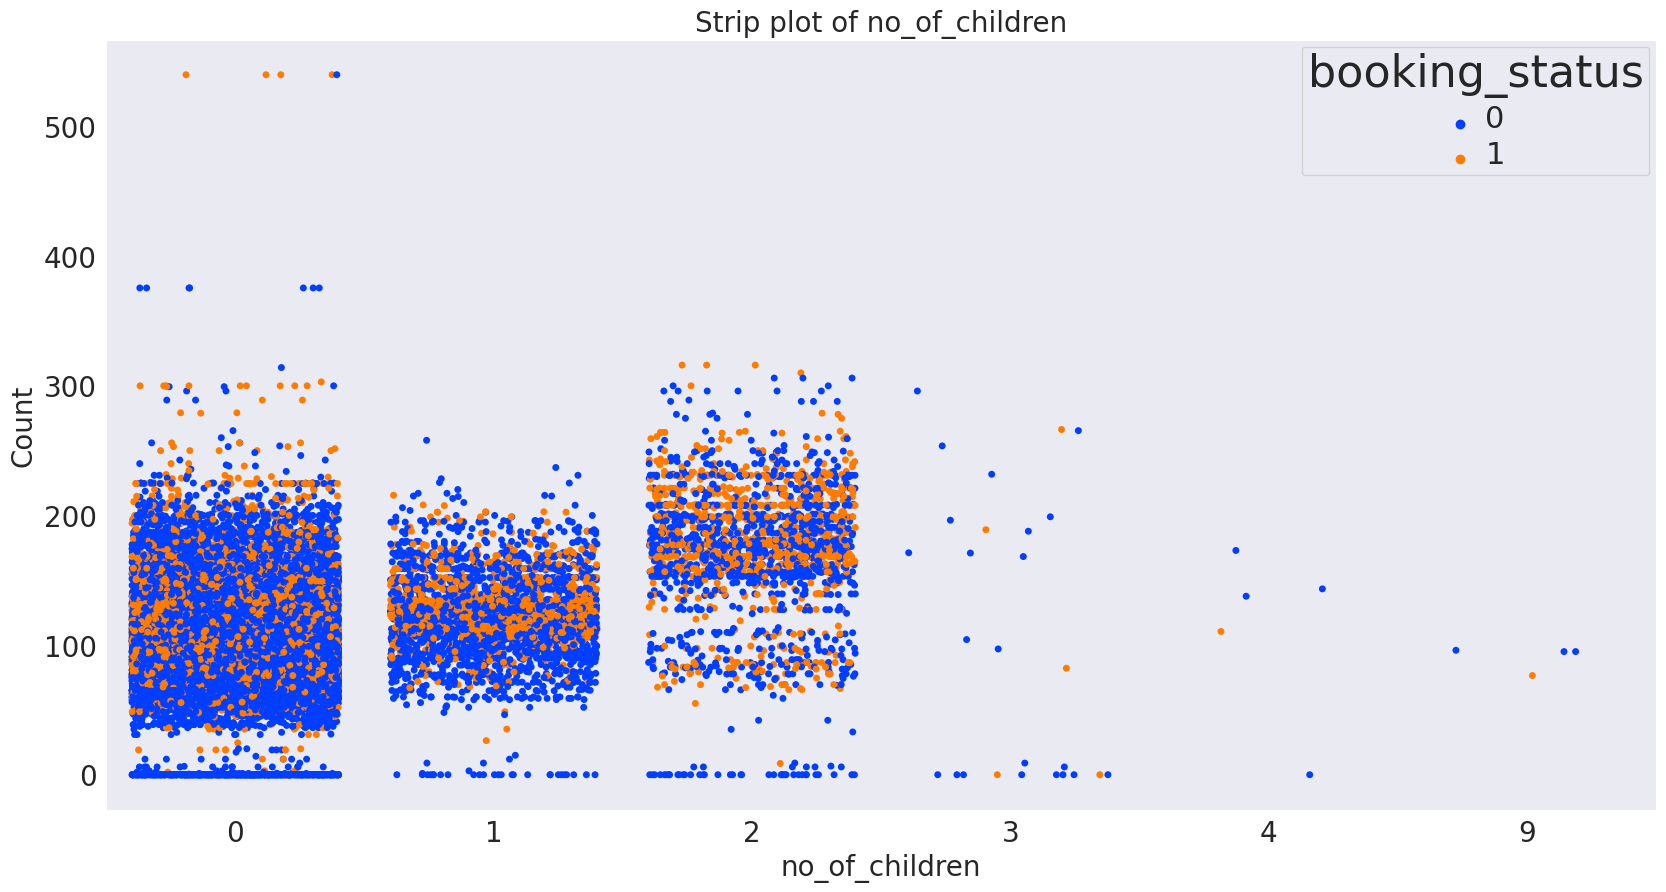

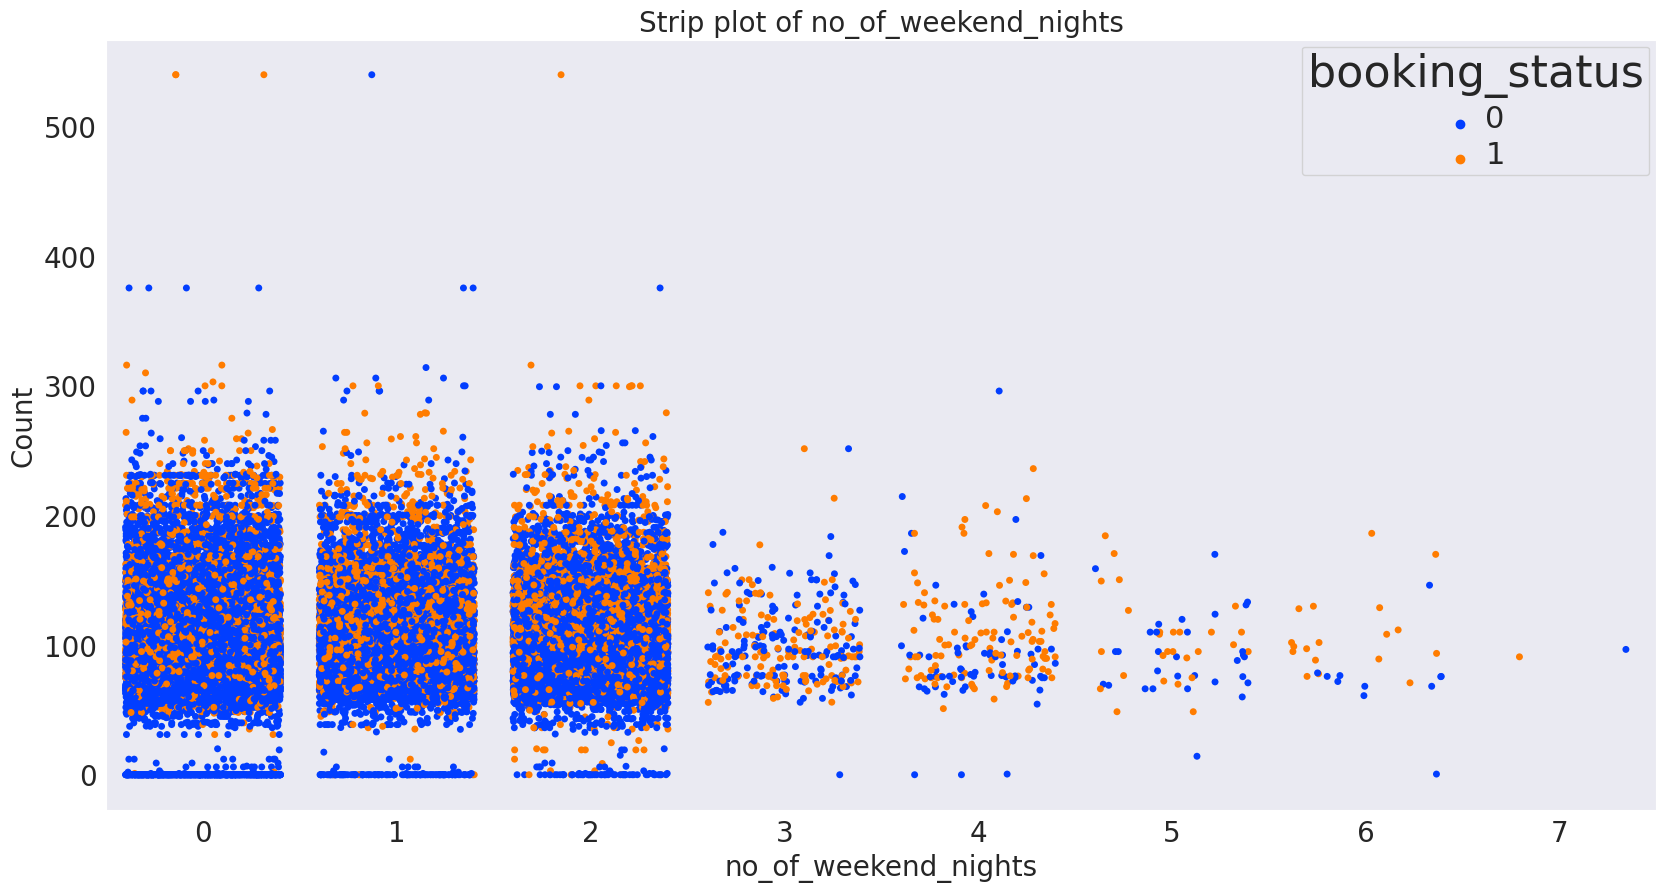

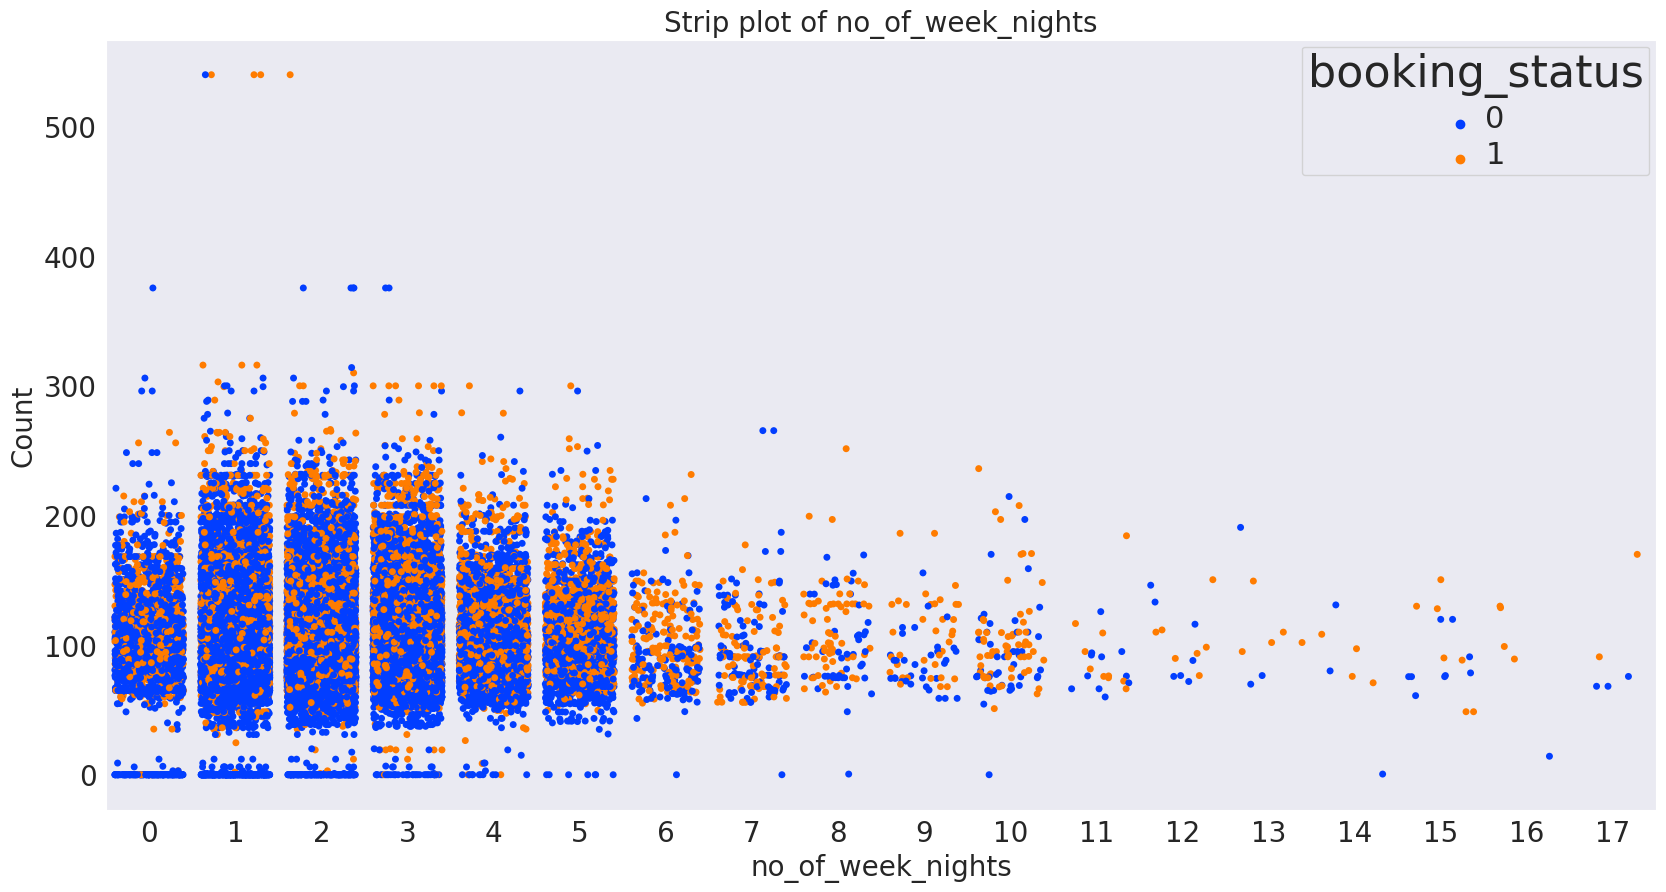

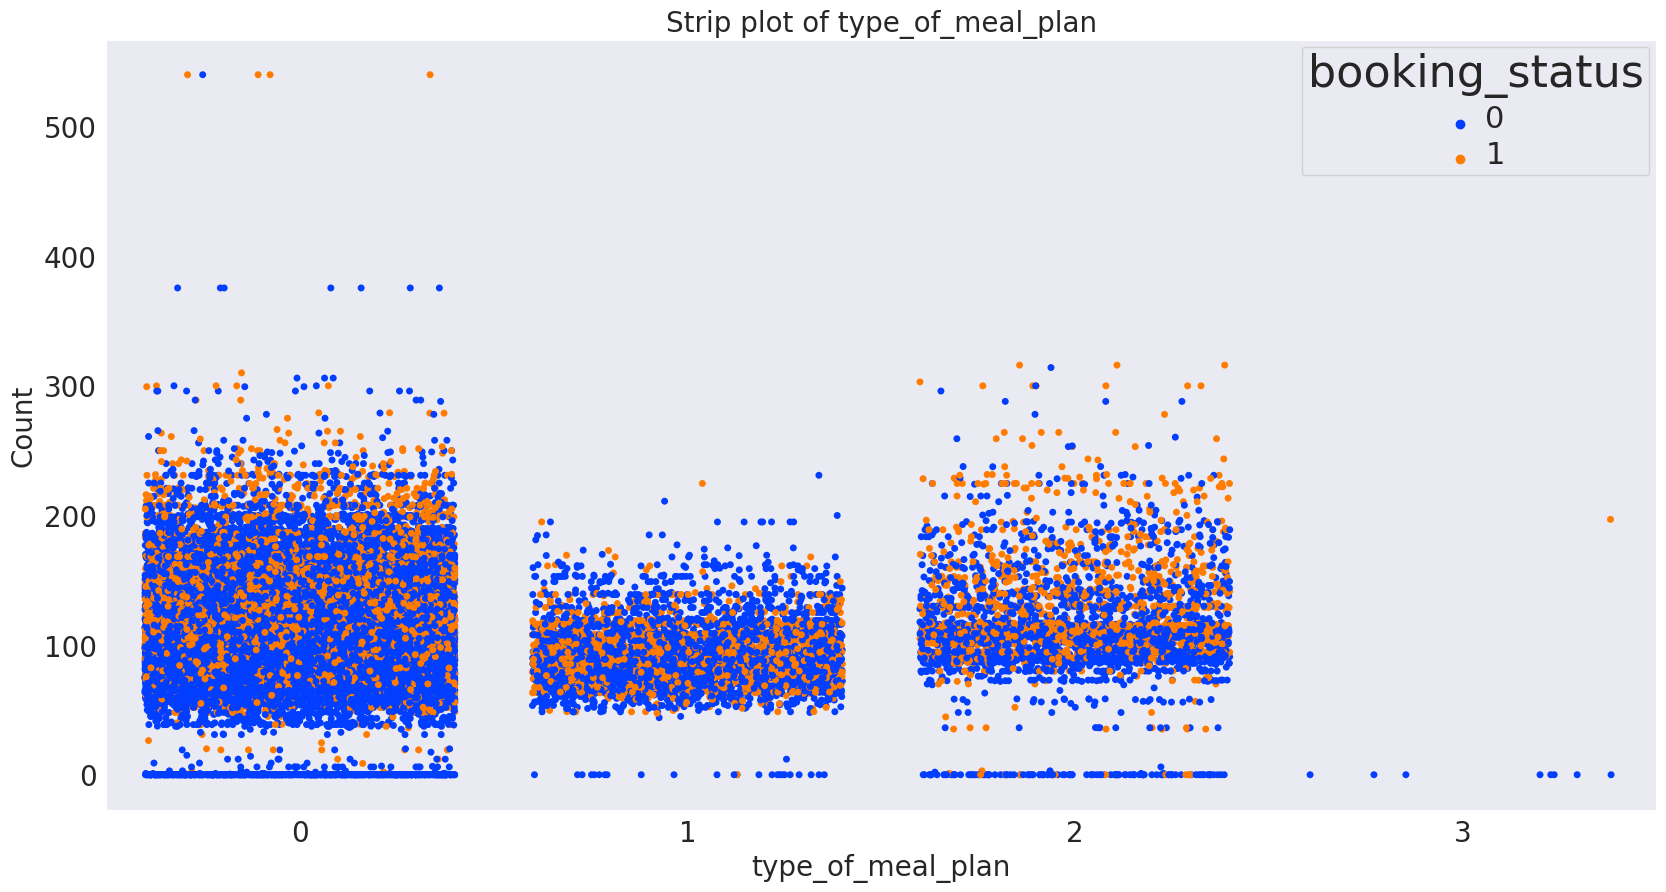

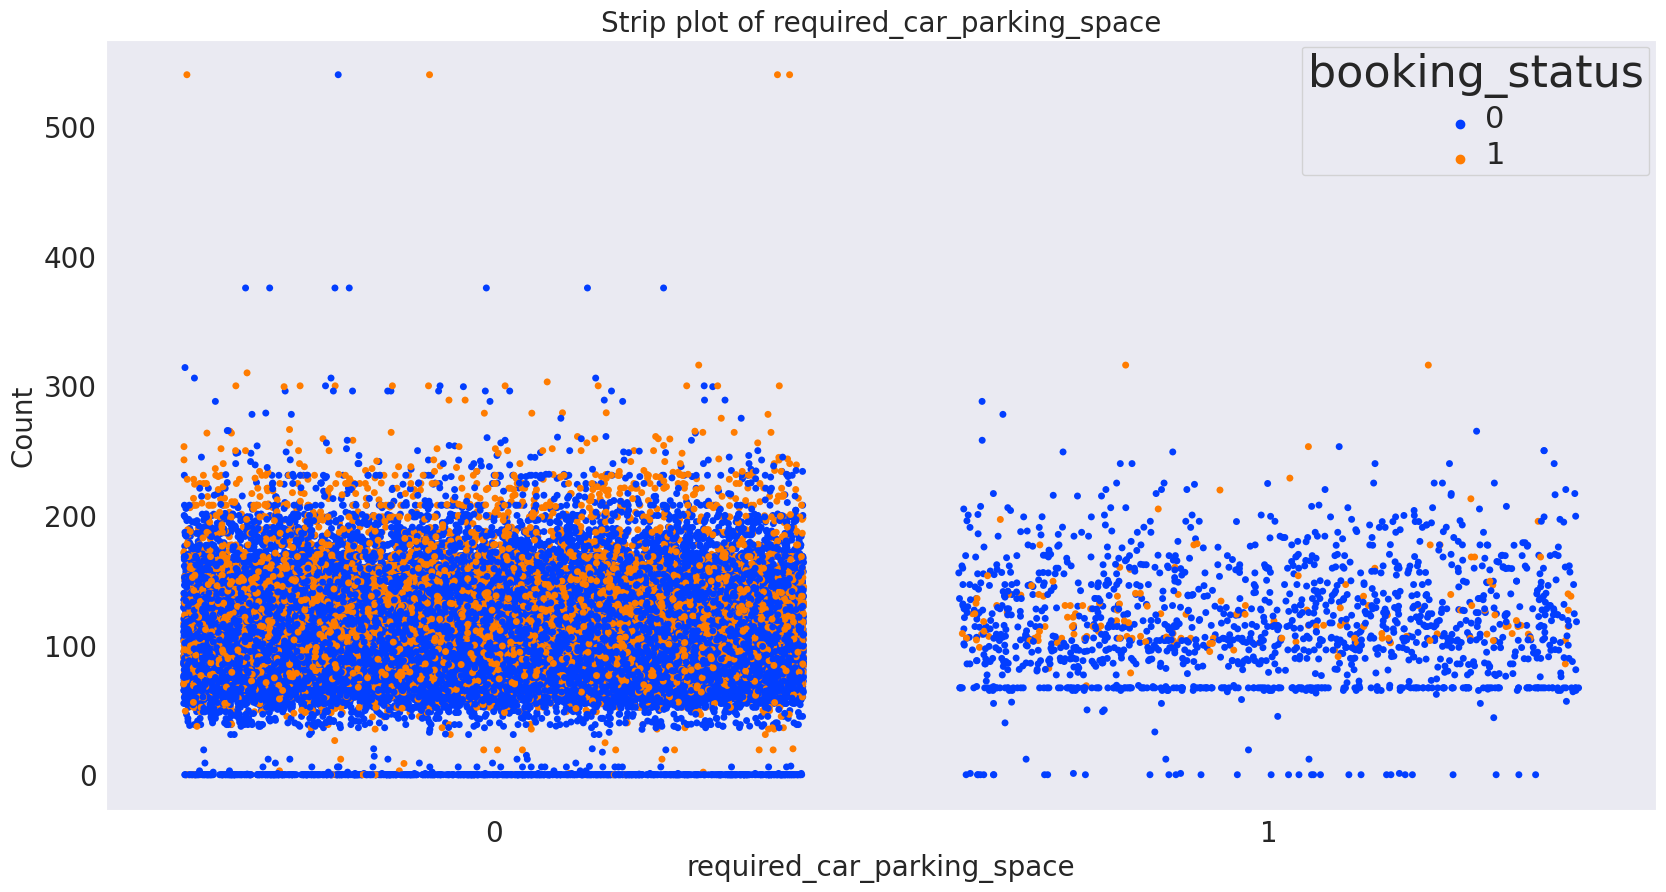

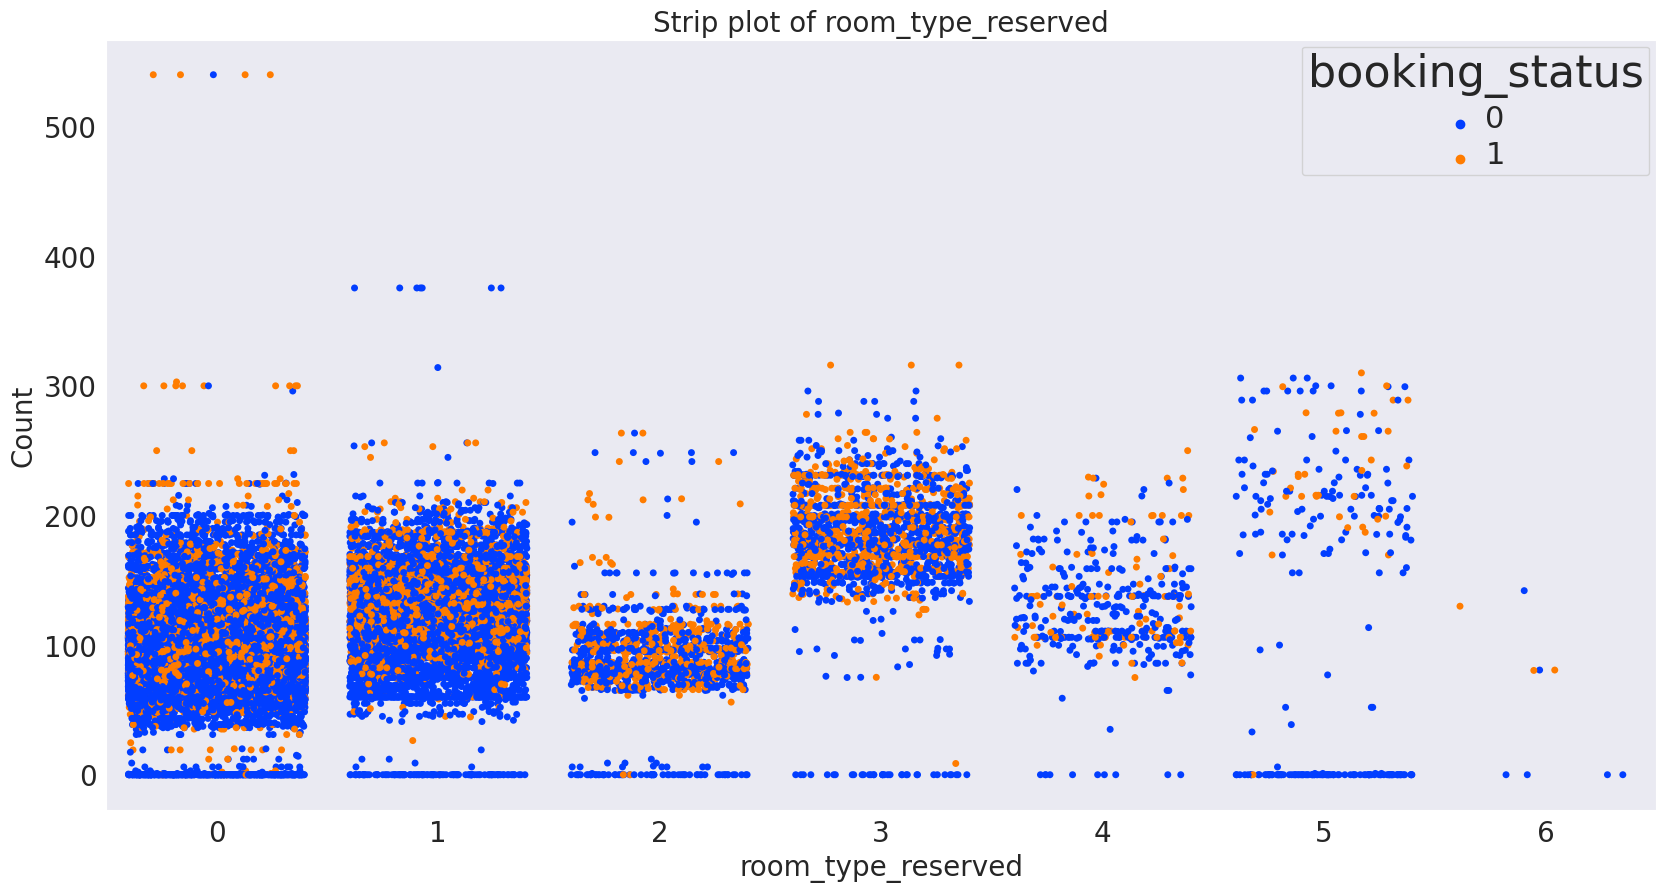

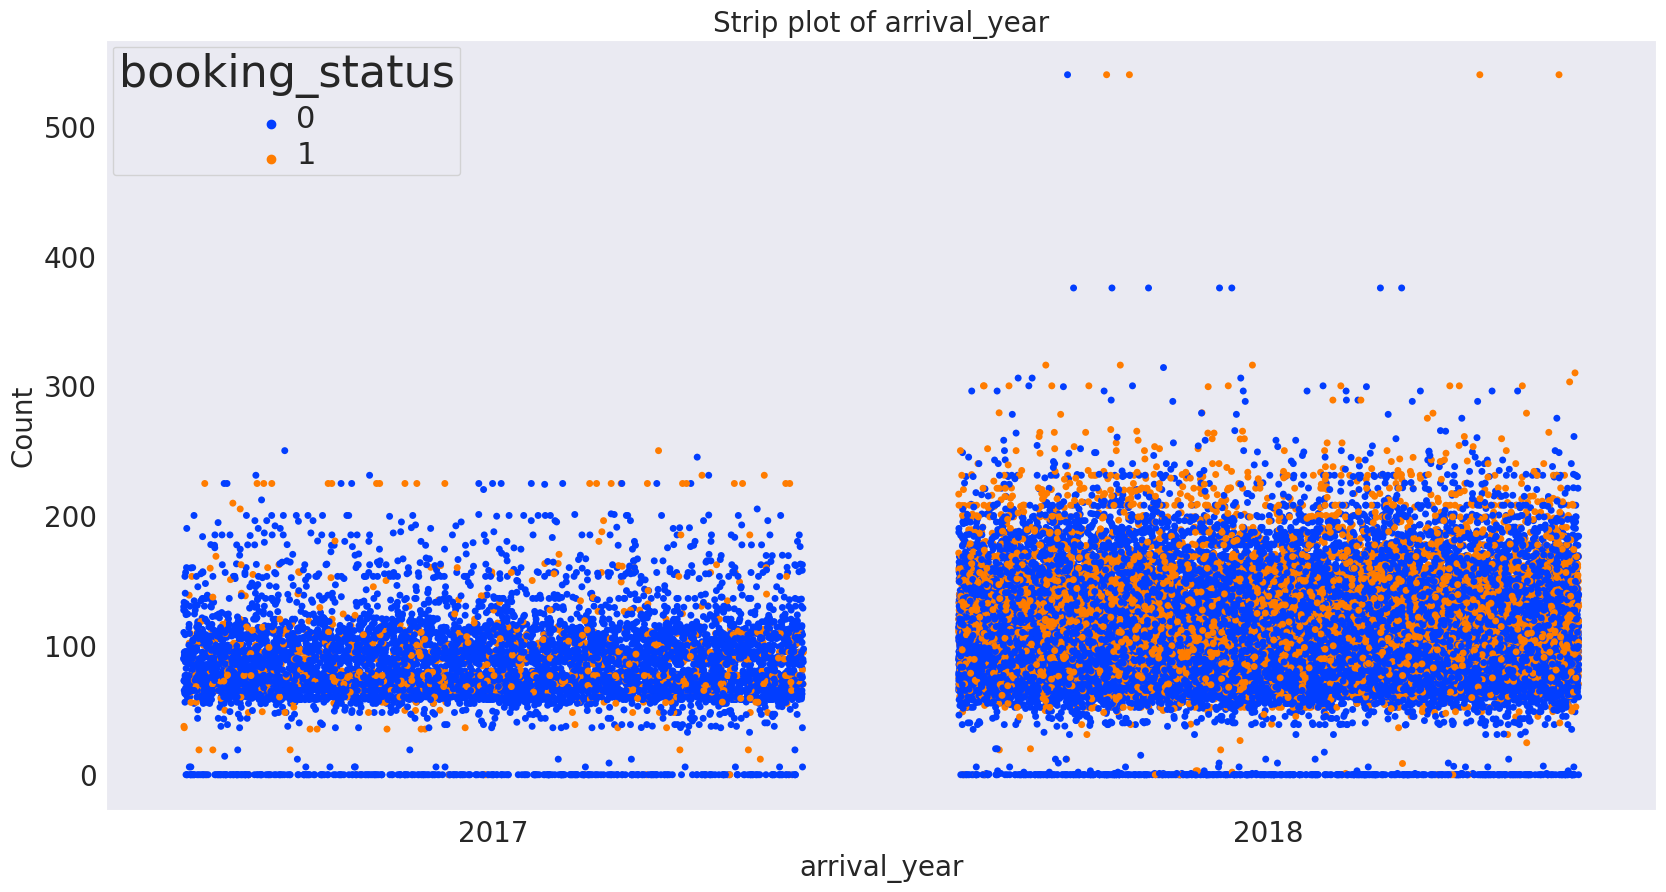

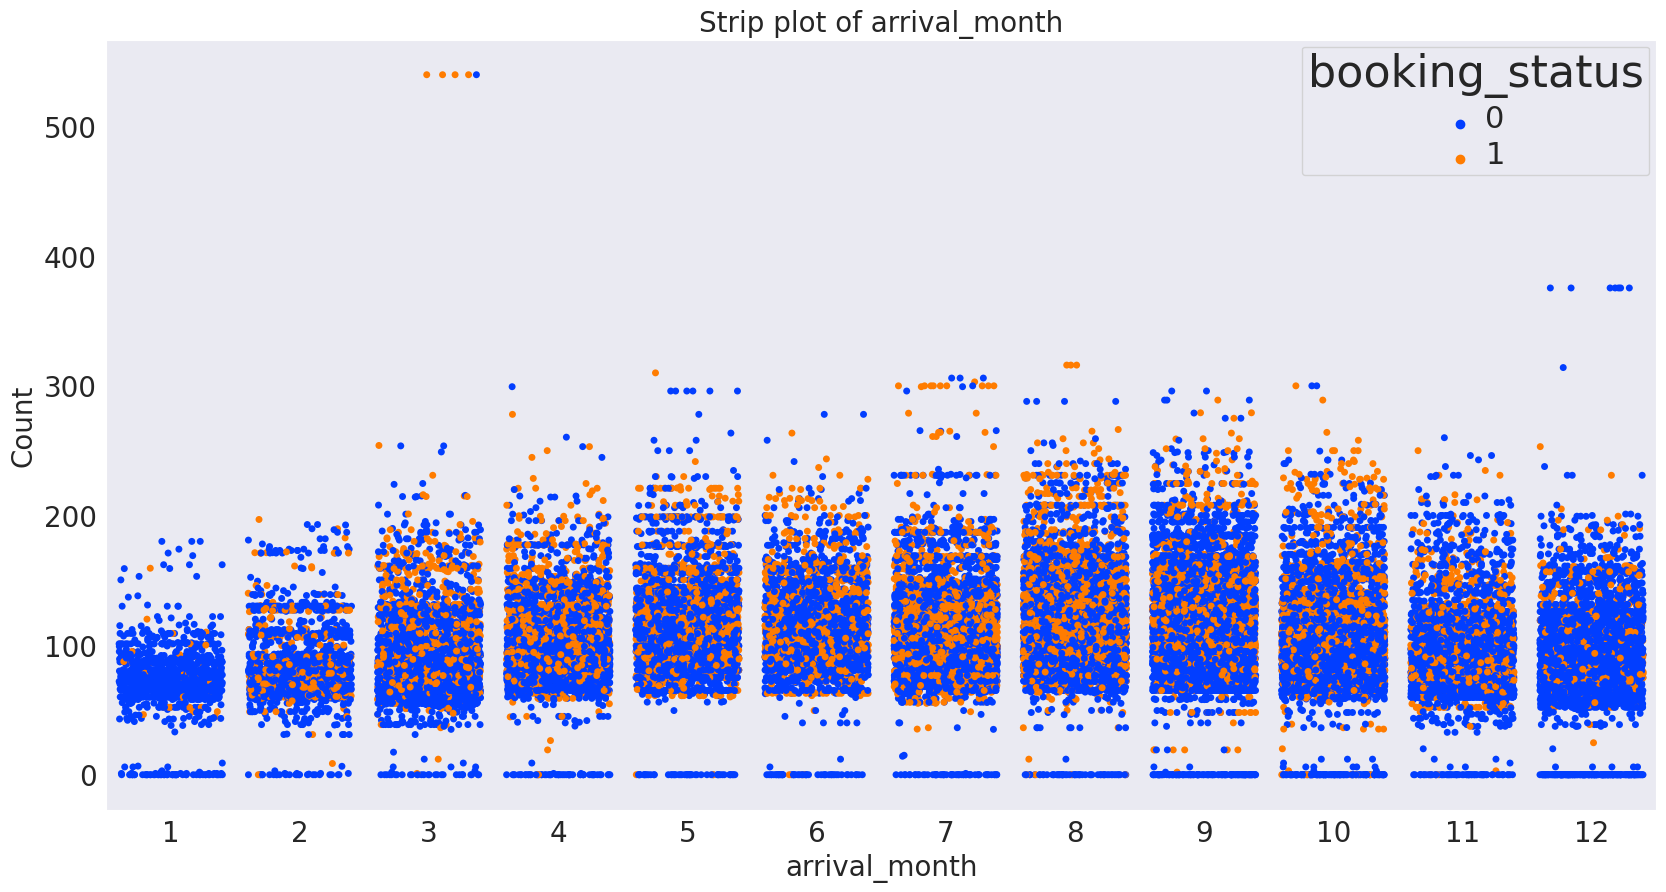

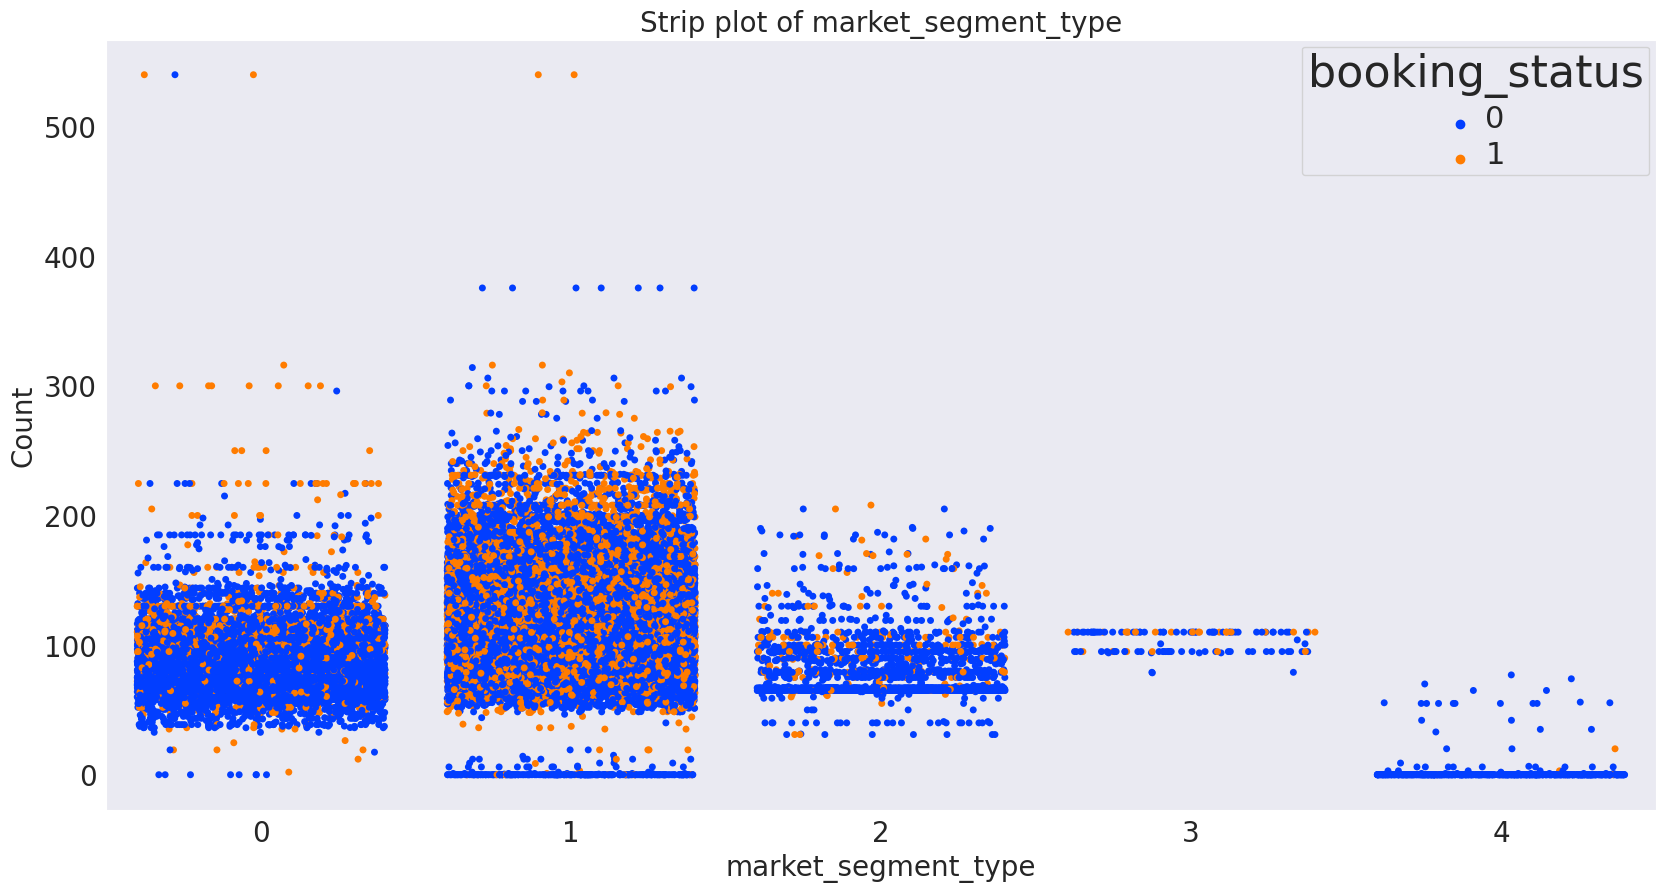

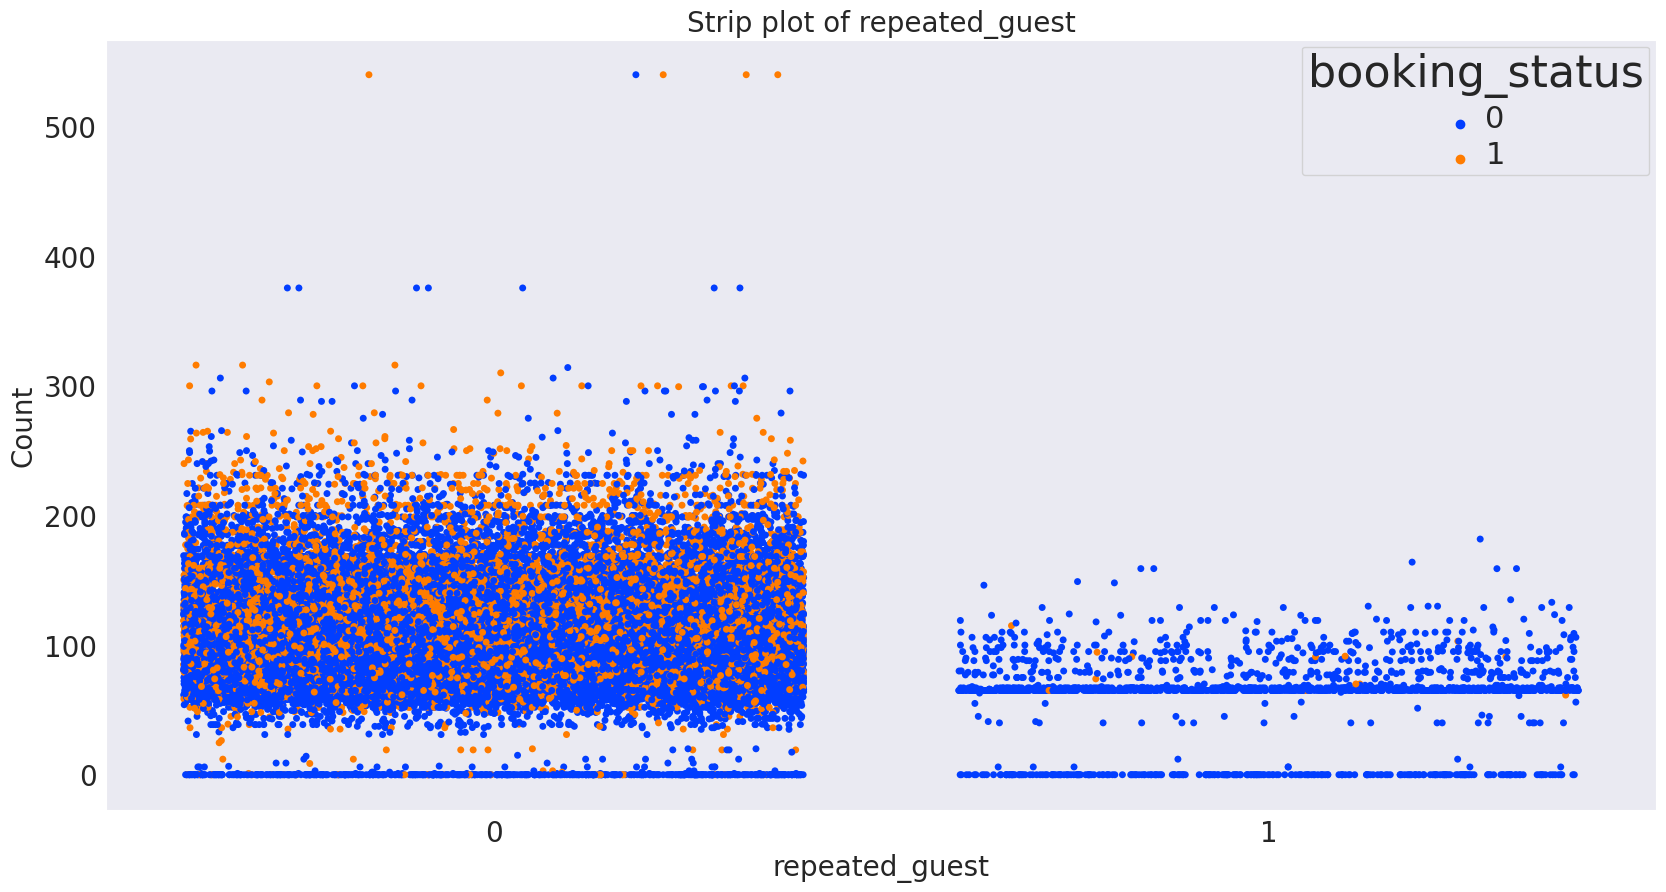

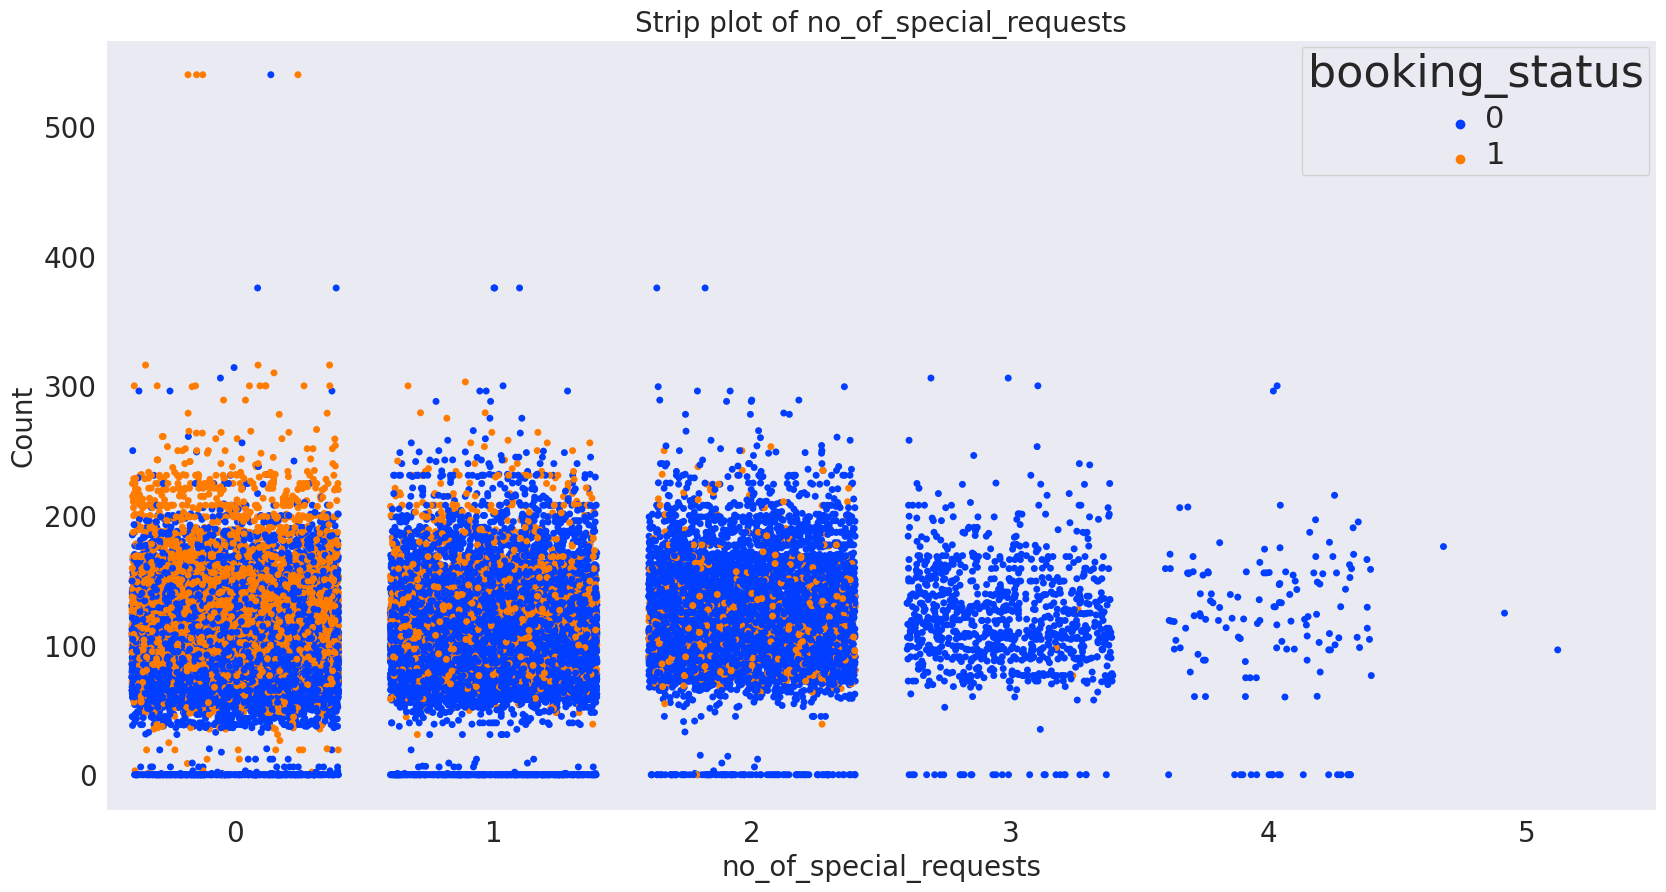

In [12]:
#showing the stripplot of avg_price_per_room and some categorical variables according to the target column
for i in categorical_columns:
    
    plt.figure(figsize=(20,10))
    sns.set_style("dark")
    plot= sns.stripplot(data=df_train, x=i ,y='avg_price_per_room',
                  hue='booking_status',jitter=0.4,palette='bright',legend='auto')
    plt.xticks(size=20)
    plt.xlabel(i,size=20)
    plt.yticks(size=20)
    plt.ylabel('Count',size=20)
    plt.title('Strip plot of ' + i,size=20)
    plt.setp(plot.get_legend().get_texts(), size=22) # for legend text
    plt.setp(plot.get_legend().get_title(), size=32) # for legend title
    plt.show()
    

In [13]:
# correlation using pearson method
df_train.corr(method='pearson')['booking_status'].sort_values(ascending=False)

booking_status                          1.000000
lead_time                               0.381204
arrival_year                            0.174810
avg_price_per_room                      0.155123
no_of_adults                            0.088383
no_of_week_nights                       0.079705
market_segment_type                     0.072038
no_of_weekend_nights                    0.050427
type_of_meal_plan                       0.044580
no_of_children                          0.018774
arrival_date                            0.006199
arrival_month                           0.004918
room_type_reserved                     -0.002091
no_of_previous_cancellations           -0.042976
no_of_previous_bookings_not_canceled   -0.076134
required_car_parking_space             -0.096855
repeated_guest                         -0.129976
no_of_special_requests                 -0.234988
Name: booking_status, dtype: float64

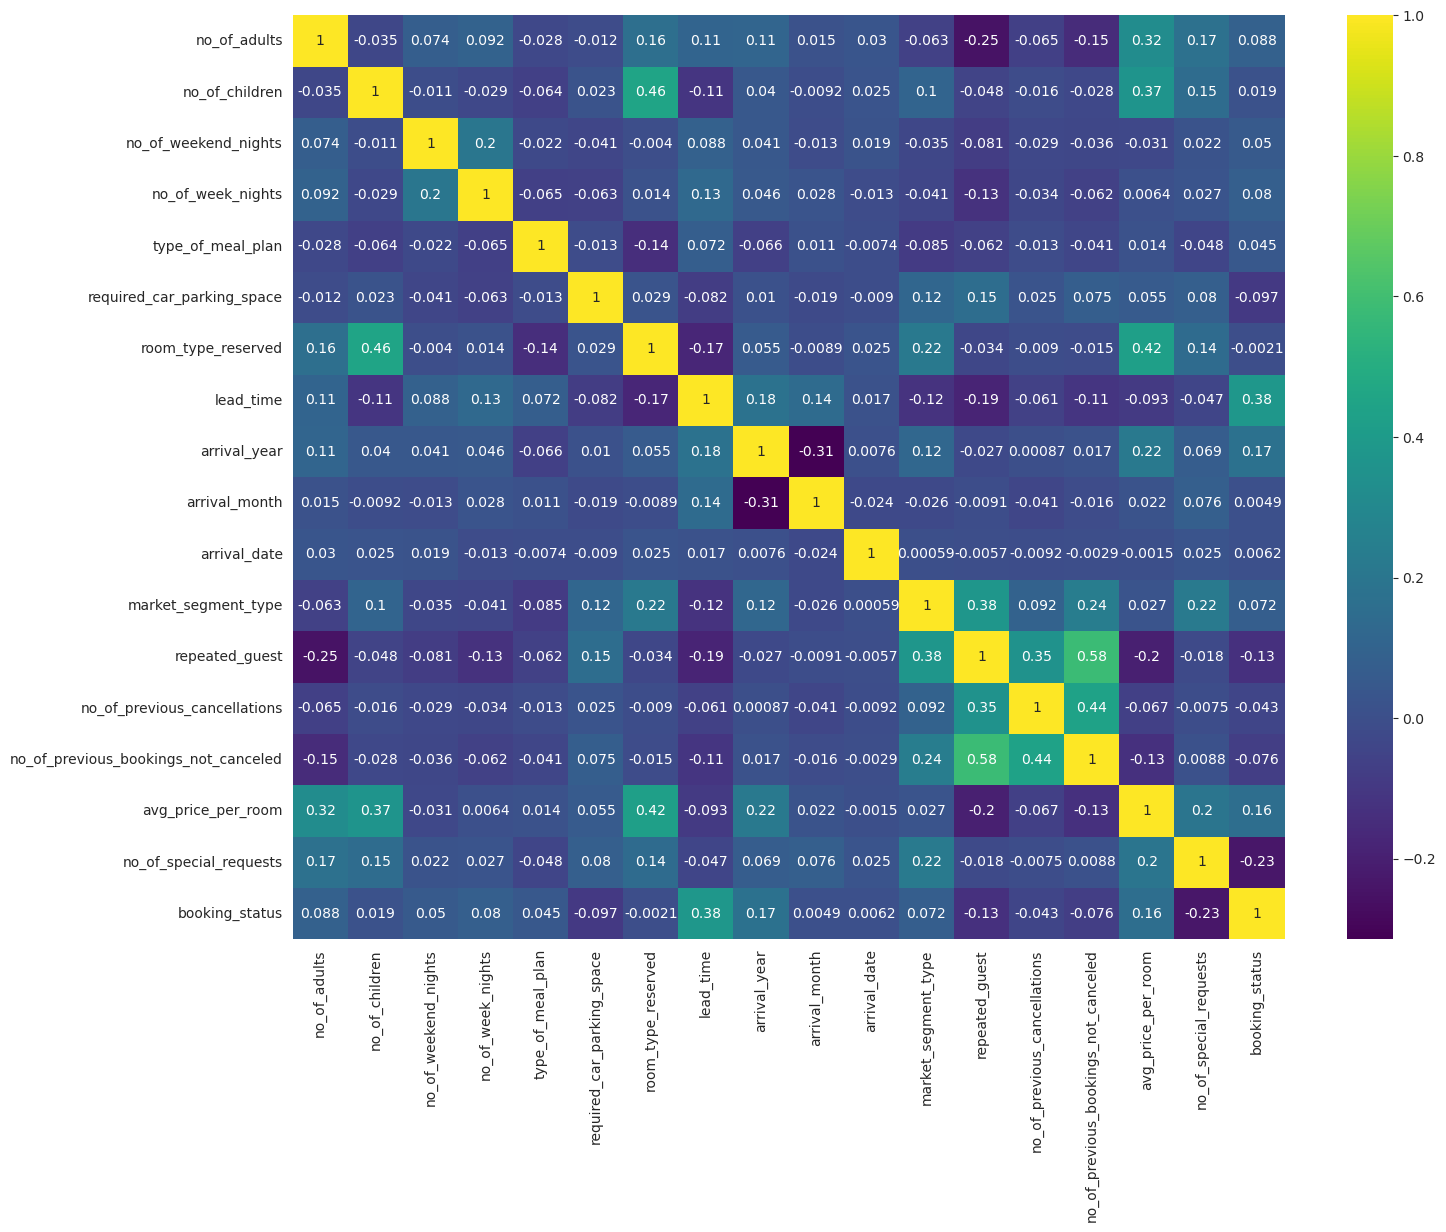

In [14]:
#showing the correlation as a heatmap 
plt.figure(figsize=(16,12))
sns.heatmap(df_train.corr(method='pearson'), annot=True, cmap='viridis')
plt.show()

### seperating the target column from the features

In [15]:
X_train = df_train.drop(['booking_status'],axis = 1)
y_train = df_train.pop('booking_status')
X_test = df_test

### Feature Engineering

In [16]:
#fixing some date values 
# Creates a dummy date to find days_in_month and clips the values by assignment.
X_train['arrival_year_month'] = pd.to_datetime(X_train['arrival_year'].astype(str)
                                            +X_train['arrival_month'].astype(str), format='%Y%m')
X_test['arrival_year_month'] = pd.to_datetime(X_test['arrival_year'].astype(str)
                                            +X_test['arrival_month'].astype(str), format='%Y%m')

X_train.loc[X_train.arrival_date > X_train.arrival_year_month.dt.days_in_month, 'arrival_date'] = X_train.arrival_year_month.dt.days_in_month
X_test.loc[X_test.arrival_date > X_test.arrival_year_month.dt.days_in_month, 'arrival_date'] = X_test.arrival_year_month.dt.days_in_month

X_train.drop(columns='arrival_year_month', inplace=True)
X_test.drop(columns='arrival_year_month', inplace=True)

In [17]:
#helper function to encode cyclical features
def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df.drop(col,axis=1,inplace=True)
    return df

In [18]:
# turning month and day date to cyclical features
X_train = encode_cyclical(X_train, 'arrival_month', 12)
X_train = encode_cyclical(X_train, 'arrival_date', 31)

df_test = encode_cyclical(df_test, 'arrival_month', 12)
df_test = encode_cyclical(df_test, 'arrival_date', 31)

In [19]:
# #selecting best 12 features from the 19 features columns
# select = SelectKBest( k=14)

# X_train = select.fit_transform(X_train,y_train)
# X_train = pd.DataFrame(X_train, columns=select.get_feature_names_out() )

# X_test = select.transform(df_test)
# X_test = pd.DataFrame(X_test, columns=select.get_feature_names_out(), index=df_test.index )

In [20]:
# one hot encoding some important features that are not ordinal or binary 
# and scaling some features that needs to be scalled

transformer = make_column_transformer(
    (OneHotEncoder(), ['type_of_meal_plan','arrival_year','market_segment_type','room_type_reserved'
                      ]),
    #(StandardScaler(), ['lead_time','avg_price_per_room']),
    remainder='passthrough')

transformed_train = transformer.fit_transform(X_train)
transformed_test = transformer.transform(df_test)


X_train = pd.DataFrame(
    transformed_train, 
    columns=transformer.get_feature_names_out()
)

X_test= pd.DataFrame(
    transformed_test, 
    columns=transformer.get_feature_names_out(),
    index=df_test.index
)

In [21]:
# X_test = df_test

In [22]:
# pd.set_option('display.max_columns', None)
# X_train.describe()

## XGB Boost classifier


In [23]:
xgb_model = XGBClassifier(eval_metric=roc_auc_score,
                          objective='binary:logistic',
                          n_estimators = 1000,
                          max_depth= 8,
                          learning_rate=0.05,
                          n_jobs =-1,
                          subsample =0.7,
                          colsample_bytree=0.4
                        )
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=<function roc_auc_score at 0x7fca26783a70>, gamma=0,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=8, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [24]:
cross_val_score(estimator=xgb_model, X=X_train, y=y_train, scoring='roc_auc')

array([0.89576021, 0.90182333, 0.89938326, 0.89880561, 0.90399115])

### XGB Tuning

In [25]:
xgb_param ={'n_estimators': [100,150,200,250,300,600,700,1000,2000],
   "learning_rate": [0.05, 0.10, 0.15 ],
   "max_depth": [ 3, 4, 5, 6, 8, 10, 12, 15],
   "min_child_weight": [ 1, 3, 5, 7 ],
   "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
   "colsample_bytree": [ 0.3, 0.4, 0.5 , 0.7,0.9 ],
    'subsample' :[0.7,0.8,0.9]    
}

xgb_search = RandomizedSearchCV(estimator=XGBClassifier(),
                            param_distributions=xgb_param,
                            cv=5,
                            verbose=1,
                            n_jobs=-1,
                            n_iter = 30
                            )

xgb_search.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, r

In [26]:
best_xgb = xgb_search.best_estimator_
xgb_search.best_params_

{'subsample': 0.9,
 'n_estimators': 300,
 'min_child_weight': 1,
 'max_depth': 8,
 'learning_rate': 0.05,
 'gamma': 0.3,
 'colsample_bytree': 0.4}

In [27]:
cross_val_score(estimator=best_xgb, X=X_train, y=y_train, scoring='roc_auc')

array([0.89626726, 0.90214477, 0.90123136, 0.89988005, 0.90776873])

In [28]:
xgb_predictions = best_xgb.predict(X_test)

In [29]:
xgb_predictions = pd.DataFrame({'id':df_test.index,'booking_status':xgb_predictions})
xgb_predictions.to_csv('xgb_predictions.csv',index=False)

## CatBoost Classifier

In [30]:
cat_model = CatBoostClassifier(iterations=900, 
                               depth=4, 
                               learning_rate=0.08, 
                               verbose=0
                               )
cat_model.fit(X_train,y_train)

In [31]:
cross_val_score(estimator=cat_model, X=X_train, y=y_train, scoring='roc_auc')

array([0.89221929, 0.89785392, 0.89757934, 0.89681912, 0.90232829])

### CatBoost Tuning

In [32]:
cat_parameters = {'iterations':np.arange(100,1000,100), 
                          'depth':np.arange(1,5,1), 
                          'learning_rate':[0.05,0.08]}

search_catboost = GridSearchCV(estimator=cat_model, param_grid=cat_parameters, 
                                         verbose=1,cv=5)

search_catboost.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fc9f9d86cd0>,
             param_grid={'depth': array([1, 2, 3, 4]),
                         'iterations': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                         'learning_rate': [0.05, 0.08]},
             verbose=1)

In [33]:
## Get the best estimator
best_cat = search_catboost.best_estimator_  ## predict using this Model
search_catboost.best_params_

{'depth': 4, 'iterations': 900, 'learning_rate': 0.08}

In [34]:
cross_val_score(estimator=best_cat, X=X_train, y=y_train, scoring='roc_auc')

array([0.89221929, 0.89785392, 0.89757934, 0.89681912, 0.90232829])

In [35]:
cat_predictions = best_cat.predict(X_test)

In [36]:
cat_predictions = pd.DataFrame({'id':df_test.index,'booking_status':cat_predictions})
cat_predictions.to_csv('cat_predictions.csv',index=False)